<a href="https://colab.research.google.com/github/YonghwanYim/RL-toy-example/blob/main/RL_Toy_Example_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning + RL
(NASA C-MAPSS dataset)

# Data Handling

Connect with Google Drive

In [2]:
from google.colab import drive
drive.mount('content')

Mounted at content


Importing libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import warnings
np.random.seed(34)
warnings.filterwarnings('ignore')

Defining features names

In [4]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

Importing train and validation data

* Data Set : FD001
* Train trajectories : 100
* Test trajectories : 100
* Conditions : ONE (Sea Level)
* Fault Modes : ONE (HPC Degradation)

Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. here are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.





**Data Set: FD002**
*   Train trjectories: 260
*   Conditions: SIX
*   Fault Modes: ONE (HPC Degradation)

**Data Set: FD003**
* Train trjectories: 100
* Conditions: ONE (Sea Level)
* Fault Modes: TWO (HPC Degradation, Fan Degradation)

**Data Set: FD004**
* Train trjectories: 249
* Conditions: SIX
* Fault Modes: TWO (HPC Degradation, Fan Degradation)

In [5]:
dftrain = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/train_FD003_1_70.txt',sep='\s+',header=None,index_col=False,names=col_names)
dfvalid = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/train_FD003_71_100.txt',sep='\s+',header=None,index_col=False,names=col_names)
dffull_data = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/train_FD003.txt',sep='\s+',header=None,index_col=False,names=col_names)
# y_valid : A vector of true Remaining Useful Life (RUL) values for the test data.
# y_valid = pd.read_csv('/content/content/MyDrive/Colab Notebooks/NASA_Turbofan_Data/RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])
# dfvalid.shape

In [6]:
train = dftrain.copy() # Engine 1~70 (dataset 1)
valid = dfvalid.copy() # Engine 71~100 (dataset 1)
full_data = dffull_data.copy() # Engine 1~100 (dataset 1)

Data inspection

In [7]:
train

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1  \
0                1            1    -0.0005     0.0004      100.0  518.67   
1                1            2     0.0008    -0.0003      100.0  518.67   
2                1            3    -0.0014    -0.0002      100.0  518.67   
3                1            4    -0.0020     0.0001      100.0  518.67   
4                1            5     0.0016     0.0000      100.0  518.67   
...            ...          ...        ...        ...        ...     ...   
17524           70          168    -0.0022    -0.0003      100.0  518.67   
17525           70          169     0.0043    -0.0003      100.0  518.67   
17526           70          170     0.0003     0.0003      100.0  518.67   
17527           70          171    -0.0001    -0.0002      100.0  518.67   
17528           70          172    -0.0008    -0.0003      100.0  518.67   

          s_2      s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  \
0      642.36  1583.23  1396.84  14.62  ...  522.31  2388.01  8145.32  8.4246   
1      642.50  1584.69  1396.89  14.62  ...  522.42  2388.03  8152.85  8.4403   
2      642.18  1582.35  1405.61  14.62  ...  522.03  2388.00  8150.17  8.3901   
3      642.92  1585.61  1392.27  14.62  ...  522.49  2388.08  8146.56  8.3878   
4      641.68  1588.63  1397.65  14.62  ...  522.58  2388.03  8147.80  8.3869   
...       ...      ...      ...    ...  ...     ...      ...      ...     ...   
17524  643.54  1603.12  1422.68  14.62  ...  520.10  2388.22  8147.01  8.4679   
17525  643.85  1595.64  1430.62  14.62  ...  519.72  2388.19  8144.00  8.5197   
17526  643.47  1604.84  1427.24  14.62  ...  520.31  2388.23  8144.52  8.5237   
17527  643.54  1605.11  1430.07  14.62  ...  520.03  2388.26  8143.76  8.5429   
17528  644.04  1602.65  1431.45  14.62  ...  519.57  2388.24  8146.31  8.5515   

       s_16  s_17  s_18   s_19   s_20     s_21  
0      0.03   391  2388  100.0  39.11  23.3537  
1      0.03   392  2388  100.0  38.99  23.4491  
2      0.03   391  2388  100.0  38.85  23.3669  
3      0.03   392  2388  100.0  38.96  23.2951  
4      0.03   392  2388  100.0  39.14  23.4583  
...     ...   ...   ...    ...    ...      ...  
17524  0.03   396  2388  100.0  38.69  23.0561  
17525  0.03   397  2388  100.0  38.51  23.0839  
17526  0.03   396  2388  100.0  38.41  23.0512  
17527  0.03   396  2388  100.0  38.37  23.0493  
17528  0.03   396  2388  100.0  38.39  23.0936  

[17529 rows x 26 columns]

In [8]:
valid

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1  \
0              71            1    -0.0003     0.0001      100.0  518.67   
1              71            2    -0.0038    -0.0002      100.0  518.67   
2              71            3    -0.0027    -0.0003      100.0  518.67   
3              71            4     0.0029    -0.0003      100.0  518.67   
4              71            5    -0.0007     0.0002      100.0  518.67   
...           ...          ...        ...        ...        ...     ...   
7186          100          148    -0.0016    -0.0003      100.0  518.67   
7187          100          149     0.0034    -0.0003      100.0  518.67   
7188          100          150    -0.0016     0.0004      100.0  518.67   
7189          100          151    -0.0023     0.0004      100.0  518.67   
7190          100          152     0.0000     0.0003      100.0  518.67   

         s_2      s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  \
0     642.08  1581.48  1400.26  14.62  ...  517.77  2387.76  8120.80  8.4192   
1     641.52  1581.05  1394.00  14.62  ...  518.98  2387.84  8130.14  8.4414   
2     641.70  1575.72  1390.85  14.62  ...  520.35  2387.95  8132.44  8.3852   
3     642.02  1574.43  1396.86  14.62  ...  518.76  2387.56  8120.28  8.4243   
4     642.30  1580.29  1395.08  14.62  ...  519.53  2387.43  8122.43  8.4014   
...      ...      ...      ...    ...  ...     ...      ...      ...     ...   
7186  643.78  1596.01  1424.11  14.62  ...  519.66  2388.30  8138.08  8.5036   
7187  643.29  1596.38  1429.14  14.62  ...  519.91  2388.28  8144.36  8.5174   
7188  643.84  1604.53  1431.41  14.62  ...  519.44  2388.24  8135.95  8.5223   
7189  643.94  1597.56  1426.57  14.62  ...  520.01  2388.26  8141.24  8.5148   
7190  643.64  1599.04  1436.06  14.62  ...  519.48  2388.24  8136.98  8.5150   

      s_16  s_17  s_18   s_19   s_20     s_21  
0     0.03   390  2388  100.0  38.87  23.2429  
1     0.03   389  2388  100.0  38.88  23.2883  
2     0.03   392  2388  100.0  38.83  23.3616  
3     0.03   391  2388  100.0  39.01  23.2899  
4     0.03   392  2388  100.0  38.85  23.3676  
...    ...   ...   ...    ...    ...      ...  
7186  0.03   394  2388  100.0  38.44  22.9631  
7187  0.03   395  2388  100.0  38.50  22.9746  
7188  0.03   396  2388  100.0  38.39  23.0682  
7189  0.03   395  2388  100.0  38.31  23.0753  
7190  0.03   396  2388  100.0  38.56  23.0847  

[7191 rows x 26 columns]

In [9]:
full_data

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1  \
0                1            1    -0.0005     0.0004      100.0  518.67   
1                1            2     0.0008    -0.0003      100.0  518.67   
2                1            3    -0.0014    -0.0002      100.0  518.67   
3                1            4    -0.0020     0.0001      100.0  518.67   
4                1            5     0.0016     0.0000      100.0  518.67   
...            ...          ...        ...        ...        ...     ...   
24715          100          148    -0.0016    -0.0003      100.0  518.67   
24716          100          149     0.0034    -0.0003      100.0  518.67   
24717          100          150    -0.0016     0.0004      100.0  518.67   
24718          100          151    -0.0023     0.0004      100.0  518.67   
24719          100          152     0.0000     0.0003      100.0  518.67   

          s_2      s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  \
0      642.36  1583.23  1396.84  14.62  ...  522.31  2388.01  8145.32  8.4246   
1      642.50  1584.69  1396.89  14.62  ...  522.42  2388.03  8152.85  8.4403   
2      642.18  1582.35  1405.61  14.62  ...  522.03  2388.00  8150.17  8.3901   
3      642.92  1585.61  1392.27  14.62  ...  522.49  2388.08  8146.56  8.3878   
4      641.68  1588.63  1397.65  14.62  ...  522.58  2388.03  8147.80  8.3869   
...       ...      ...      ...    ...  ...     ...      ...      ...     ...   
24715  643.78  1596.01  1424.11  14.62  ...  519.66  2388.30  8138.08  8.5036   
24716  643.29  1596.38  1429.14  14.62  ...  519.91  2388.28  8144.36  8.5174   
24717  643.84  1604.53  1431.41  14.62  ...  519.44  2388.24  8135.95  8.5223   
24718  643.94  1597.56  1426.57  14.62  ...  520.01  2388.26  8141.24  8.5148   
24719  643.64  1599.04  1436.06  14.62  ...  519.48  2388.24  8136.98  8.5150   

       s_16  s_17  s_18   s_19   s_20     s_21  
0      0.03   391  2388  100.0  39.11  23.3537  
1      0.03   392  2388  100.0  38.99  23.4491  
2      0.03   391  2388  100.0  38.85  23.3669  
3      0.03   392  2388  100.0  38.96  23.2951  
4      0.03   392  2388  100.0  39.14  23.4583  
...     ...   ...   ...    ...    ...      ...  
24715  0.03   394  2388  100.0  38.44  22.9631  
24716  0.03   395  2388  100.0  38.50  22.9746  
24717  0.03   396  2388  100.0  38.39  23.0682  
24718  0.03   395  2388  100.0  38.31  23.0753  
24719  0.03   396  2388  100.0  38.56  23.0847  

[24720 rows x 26 columns]

In [10]:
print('Shape of the train dataset : ',train.shape)
print('Shape of the validation dataset : ',valid.shape)
print('Percentage of the validation dataset : ',len(valid)/(len(valid)+len(train)))

Shape of the train dataset :  (17529, 26)
Shape of the validation dataset :  (7191, 26)
Percentage of the validation dataset :  0.2908980582524272


In [11]:
# Checking the presence of Nan values
print('Total None value in the train dataset : ', train.isna().sum())
print('Total None value in the valid dataset : ', valid.isna().sum())

Total None value in the train dataset :  unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64
Total None value in the valid dataset :  unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64


In [12]:
train.loc[:,['unit_number','time_cycles']].describe()

unit_number   time_cycles
count  17529.000000  17529.000000
mean      33.517143    140.180501
std       19.943409     99.655078
min        1.000000      1.000000
25%       17.000000     63.000000
50%       33.000000    126.000000
75%       51.000000    191.000000
max       70.000000    525.000000

In [13]:
train.loc[:,'s_1':].describe().transpose()

count         mean           std        min        25%        50%  \
s_1   17529.0   518.670000  0.000000e+00   518.6700   518.6700   518.6700   
s_2   17529.0   642.456737  5.277827e-01   640.8400   642.0700   642.4000   
s_3   17529.0  1588.052022  6.865455e+00  1564.3000  1583.2000  1587.4700   
s_4   17529.0  1404.441645  9.931666e+00  1377.0600  1396.9800  1402.8600   
s_5   17529.0    14.620000  3.552815e-15    14.6200    14.6200    14.6200   
s_6   17529.0    21.596744  1.884430e-02    21.4500    21.5800    21.6100   
s_7   17529.0   554.952255  3.348767e+00   549.6100   553.0400   553.9400   
s_8   17529.0  2388.067975  1.579436e-01  2386.9000  2388.0000  2388.0700   
s_9   17529.0  9063.767836  2.057996e+01  9021.9300  9051.1500  9059.3500   
s_10  17529.0     1.301115  3.348194e-03     1.2900     1.3000     1.3000   
s_11  17529.0    47.413785  3.027559e-01    46.6900    47.1900    47.3600   
s_12  17529.0   522.868619  3.169536e+00   517.7800   521.1000   521.8900   
s_13  17529.0  2388.068168  1.576391e-01  2386.9300  2388.0000  2388.0700   
s_14  17529.0  8143.900390  1.704635e+01  8102.9200  8133.8400  8140.5300   
s_15  17529.0     8.399658  5.949510e-02     8.1563     8.3664     8.4020   
s_16  17529.0     0.030000  1.387818e-17     0.0300     0.0300     0.0300   
s_17  17529.0   392.553654  1.776825e+00   388.0000   391.0000   392.0000   
s_18  17529.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
s_19  17529.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s_20  17529.0    38.975697  2.467082e-01    38.1700    38.8200    38.9700   
s_21  17529.0    23.385844  1.474839e-01    22.8995    23.2907    23.3835   

            75%        max  
s_1    518.6700   518.6700  
s_2    642.7900   645.1100  
s_3   1592.4500  1615.3900  
s_4   1410.7500  1441.1600  
s_5     14.6200    14.6200  
s_6     21.6100    21.6100  
s_7    555.6600   570.4900  
s_8   2388.1400  2388.6000  
s_9   9069.5100  9234.3500  
s_10     1.3000     1.3200  
s_11    47.6100    48.4400  
s_12   523.4800   537.4000  
s_13  2388.1400  2388.6100  
s_14  8148.7800  8290.5500  
s_15     8.4390     8.5705  
s_16     0.0300     0.0300  
s_17   394.0000   399.0000  
s_18  2388.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    39.1300    39.8400  
s_21    23.4737    23.9505

Data Visualization & Feature Engineering


Max time cycle found for each Unit

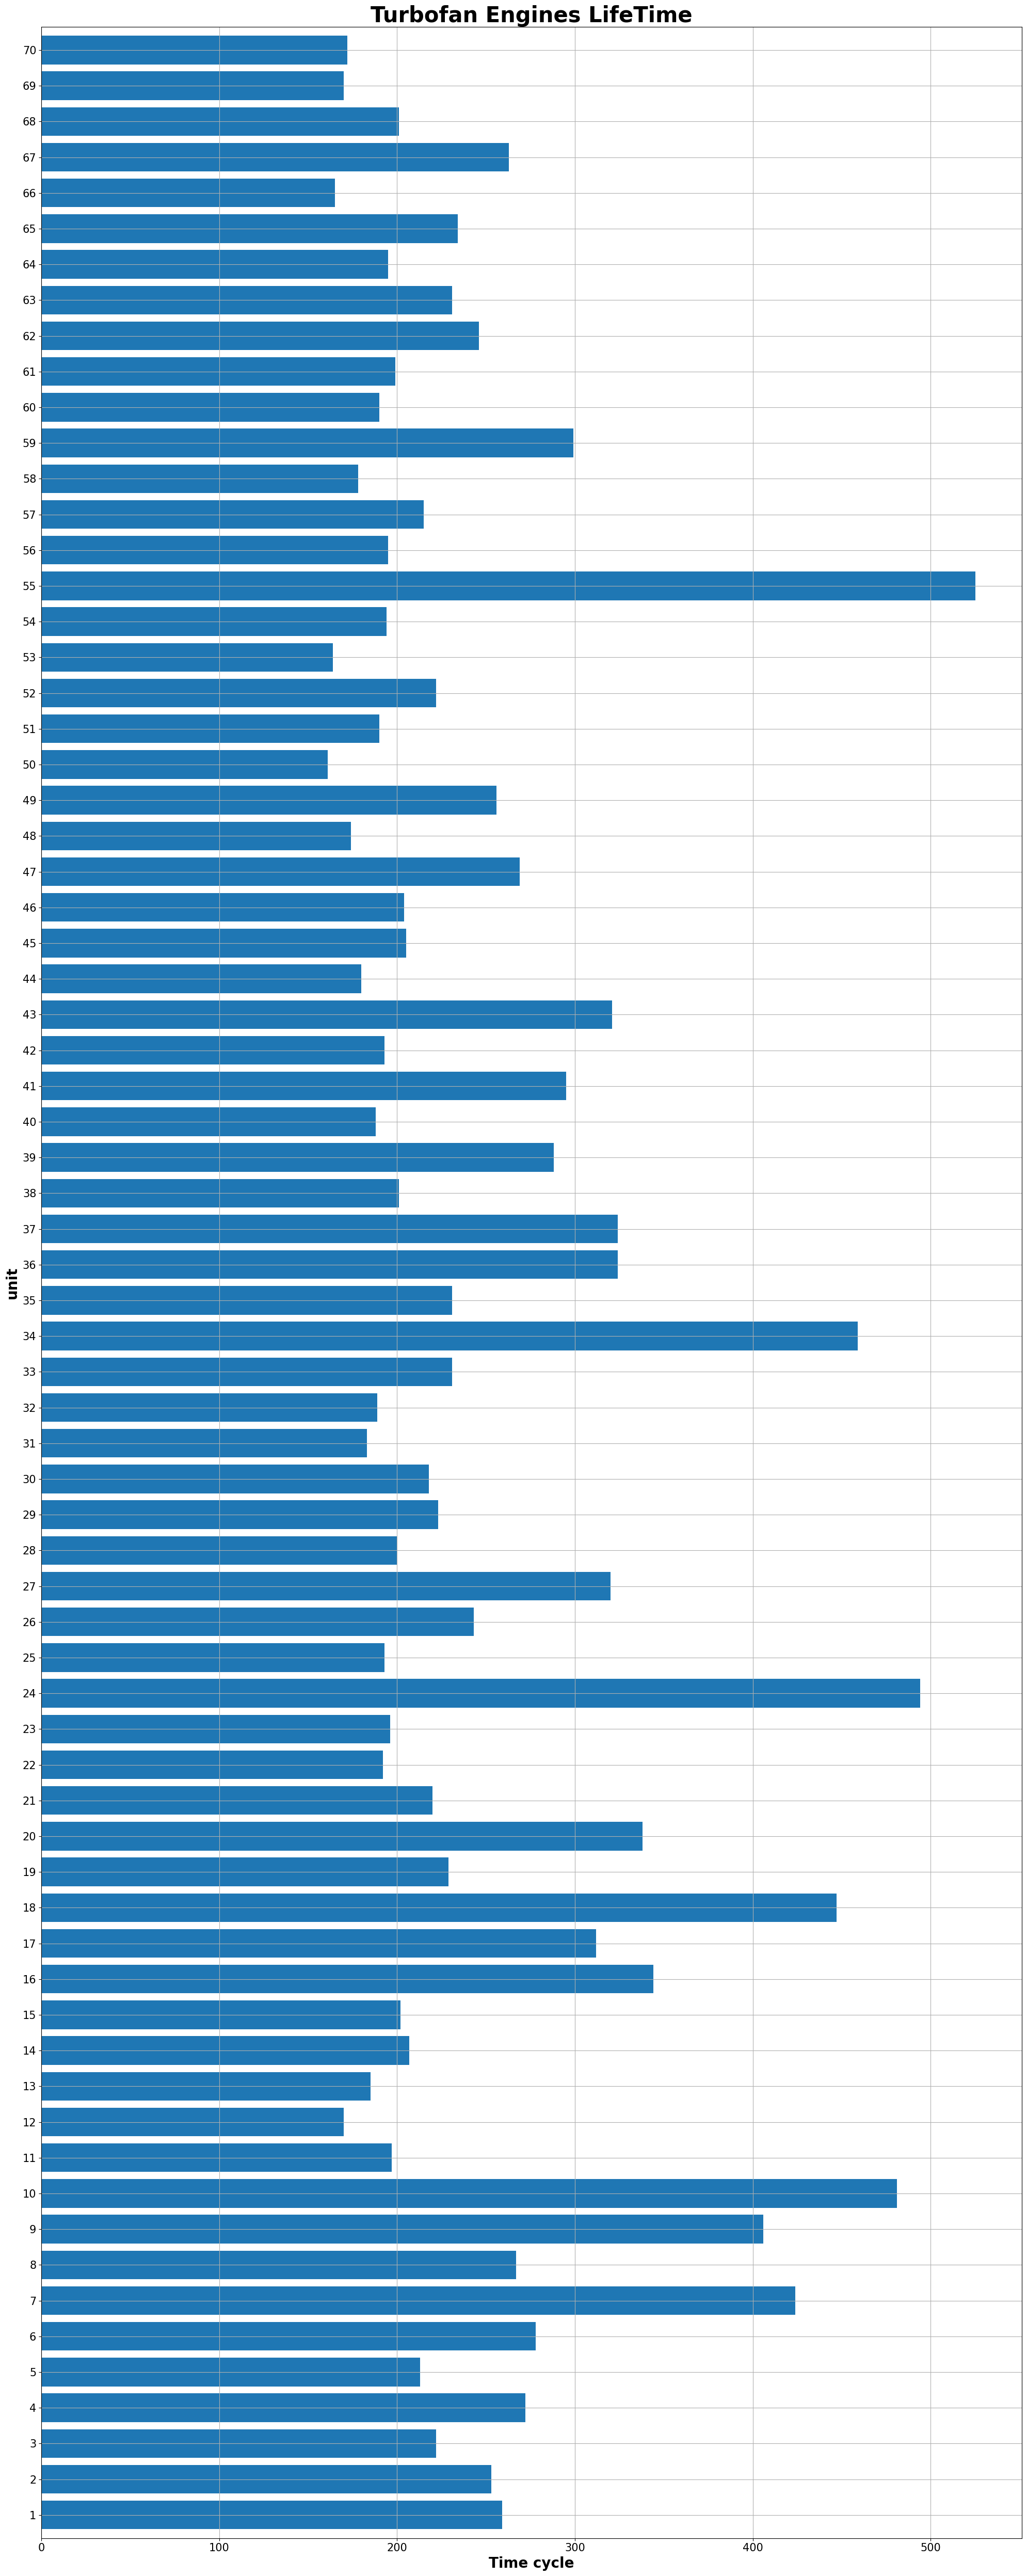

In [14]:
max_time_cycles=train[index_names].groupby('unit_number').max()  # unit_number = Index of Jet Engine (dataset 1 : 1~100)
plt.figure(figsize=(20,50))
ax=max_time_cycles['time_cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('unit',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 9.444444444444459, 'max time cycle')

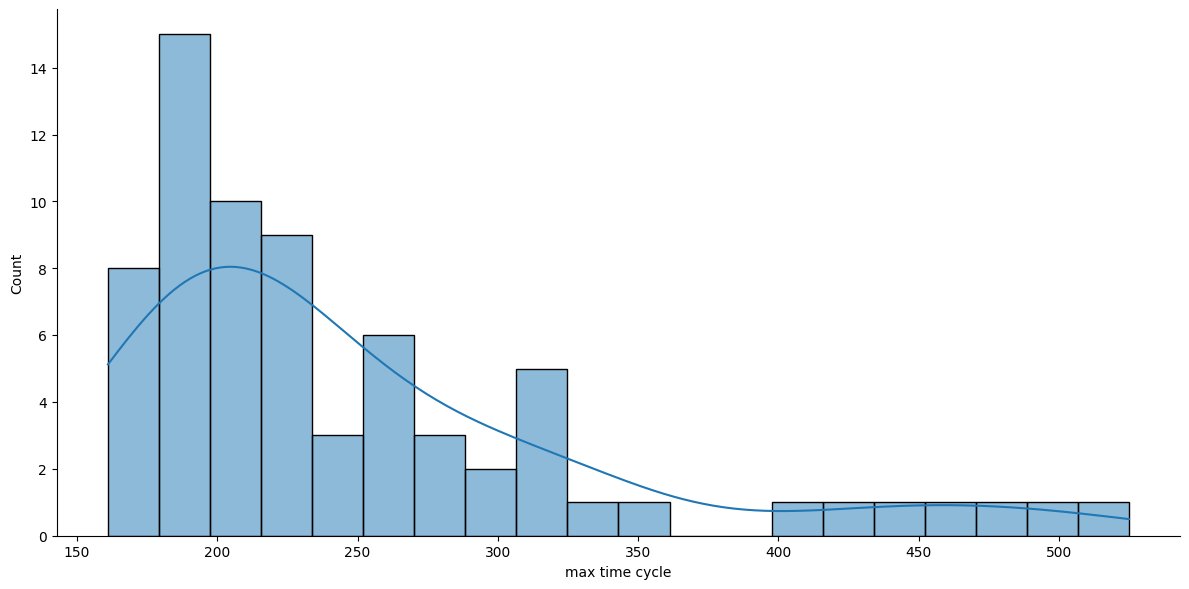

In [15]:
#Distribution of maximum time cycles
sns.displot(max_time_cycles['time_cycles'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('max time cycle')

Add RUL column to the data

RUL corresponds to the remaining time cycles for each unit before it falls.

In [16]:
def add_RUL_column(df):
    train_grouped_by_unit = df.groupby(by='unit_number')
    max_time_cycles = train_grouped_by_unit['time_cycles'].max()
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop("max_time_cycle", axis=1)
    return merged

In [17]:
train = add_RUL_column(train)
valid = add_RUL_column(valid)
full_data = add_RUL_column(full_data)

In [18]:
train[['unit_number','RUL']] # Jet Engine 1~70 (total : 70)

unit_number  RUL
0                1  258
1                1  257
2                1  256
3                1  255
4                1  254
...            ...  ...
17524           70    4
17525           70    3
17526           70    2
17527           70    1
17528           70    0

[17529 rows x 2 columns]

In [19]:
valid[['unit_number','RUL']] # Jet Engine 71~100 (total : 30)

unit_number  RUL
0              71  408
1              71  407
2              71  406
3              71  405
4              71  404
...           ...  ...
7186          100    4
7187          100    3
7188          100    2
7189          100    1
7190          100    0

[7191 rows x 2 columns]

In [20]:
full_data[['unit_number', 'RUL']]

unit_number  RUL
0                1  258
1                1  257
2                1  256
3                1  255
4                1  254
...            ...  ...
24715          100    4
24716          100    3
24717          100    2
24718          100    1
24719          100    0

[24720 rows x 2 columns]

In [21]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

Plotting the evolution of features (sensors) along with the evolution with RUL

In [22]:
def plot_signal(df, Sensor_dic, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
      #plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())
       if (i % 5 == 0):   #For a better visualisation, we plot the sensors signals of 10 units only (data : FD001)
           plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())

    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero  # xlim() : range of x-axis
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(Sensor_dic[signal_name])
    plt.xlabel('Remaining Useful Life')
    plt.show()

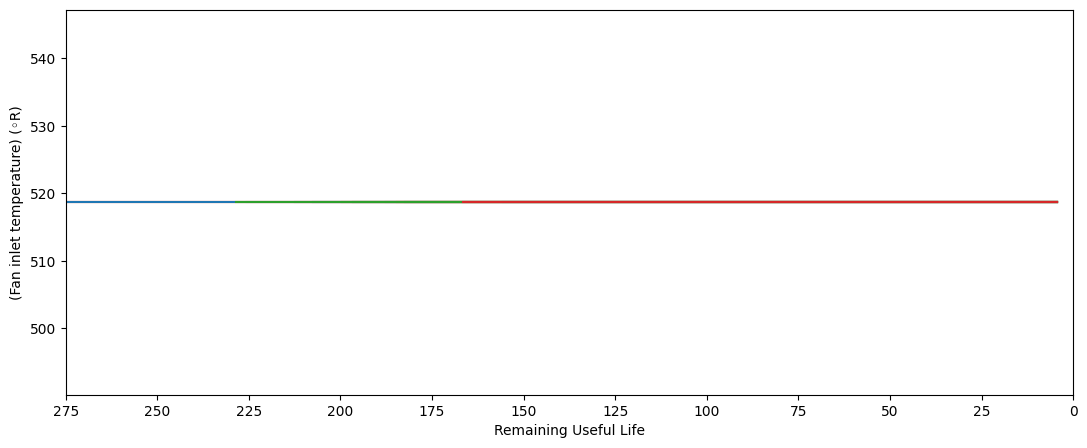

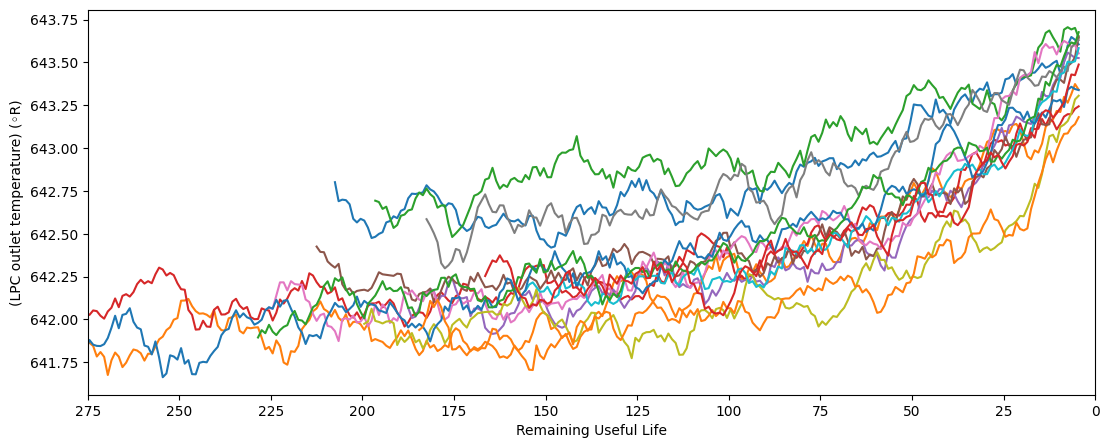

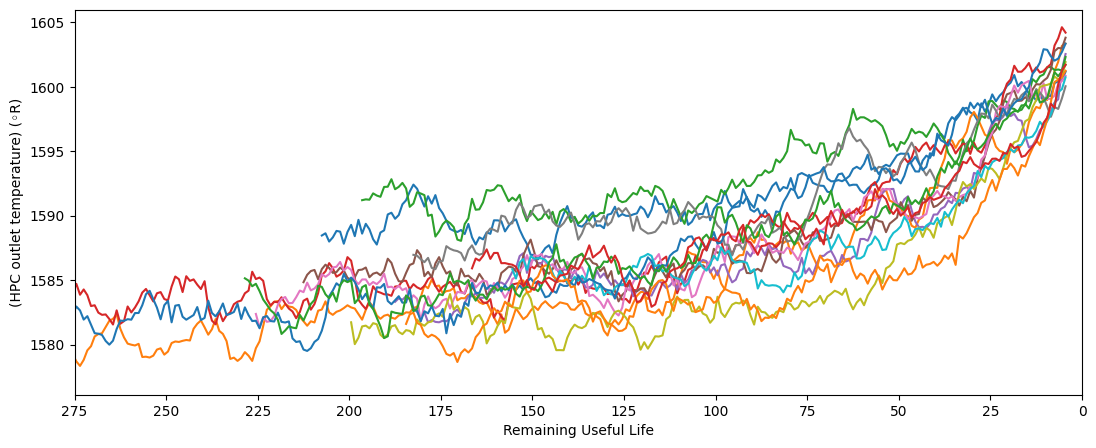

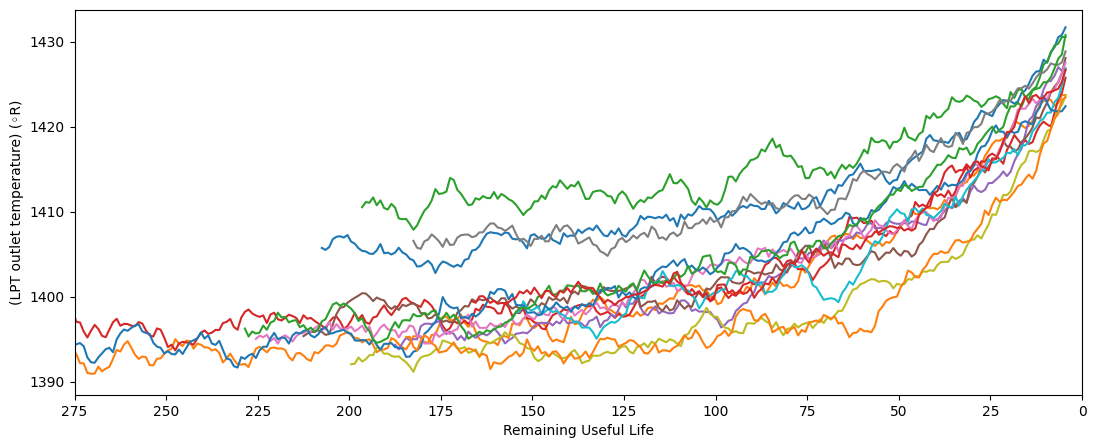

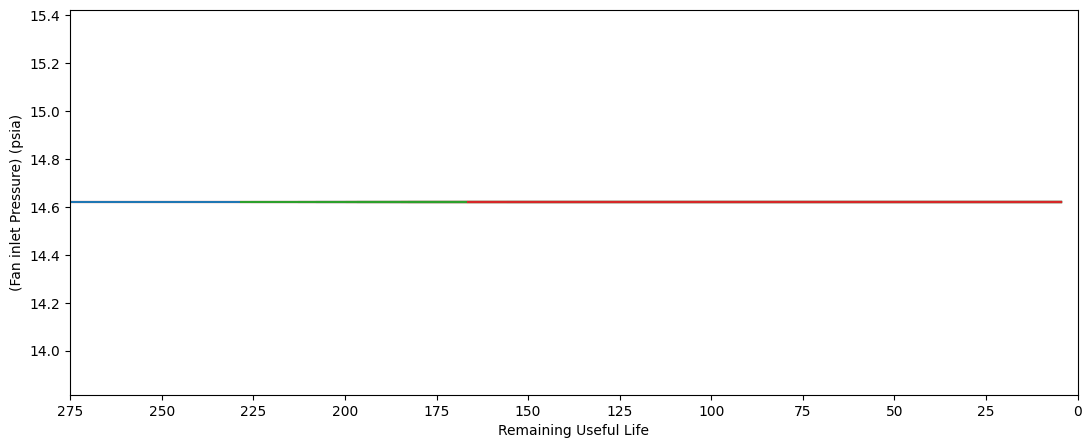

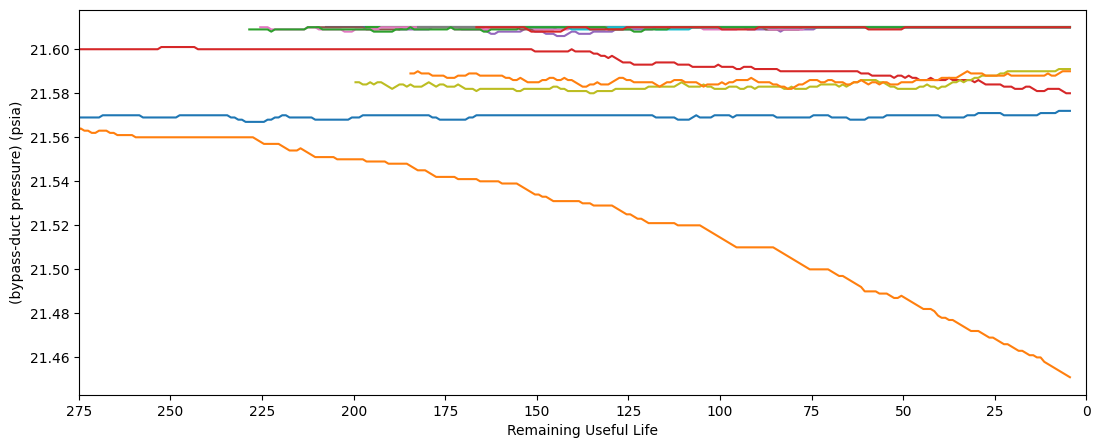

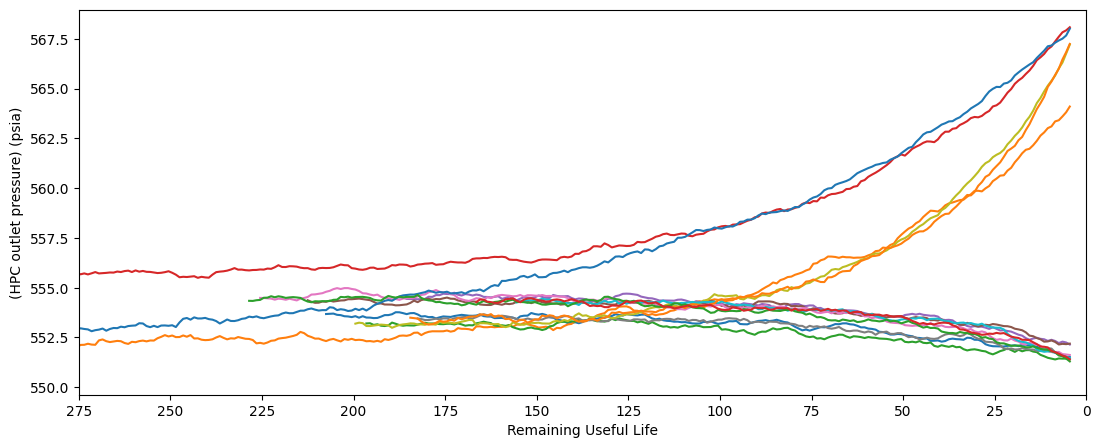

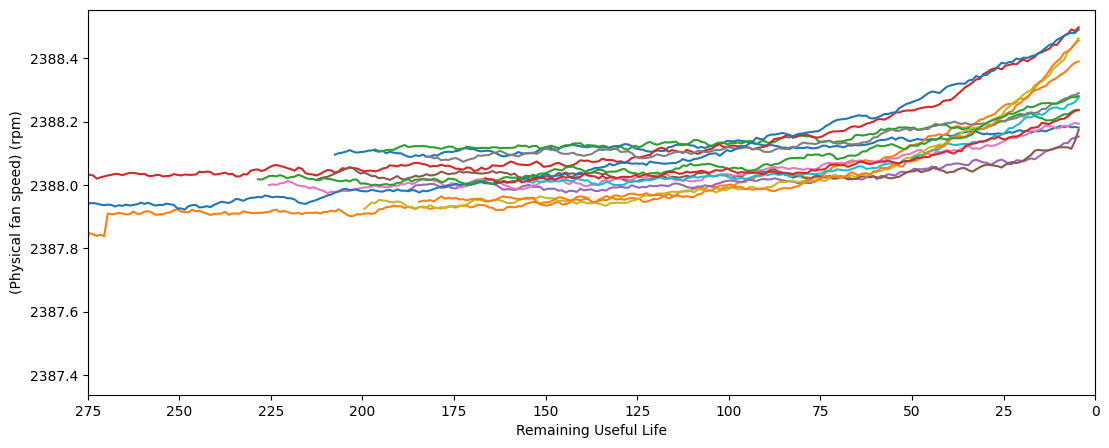

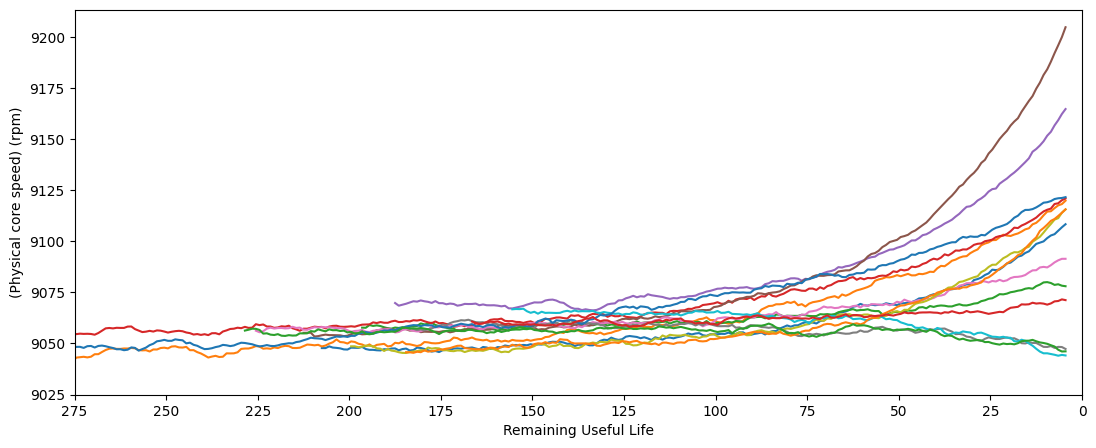

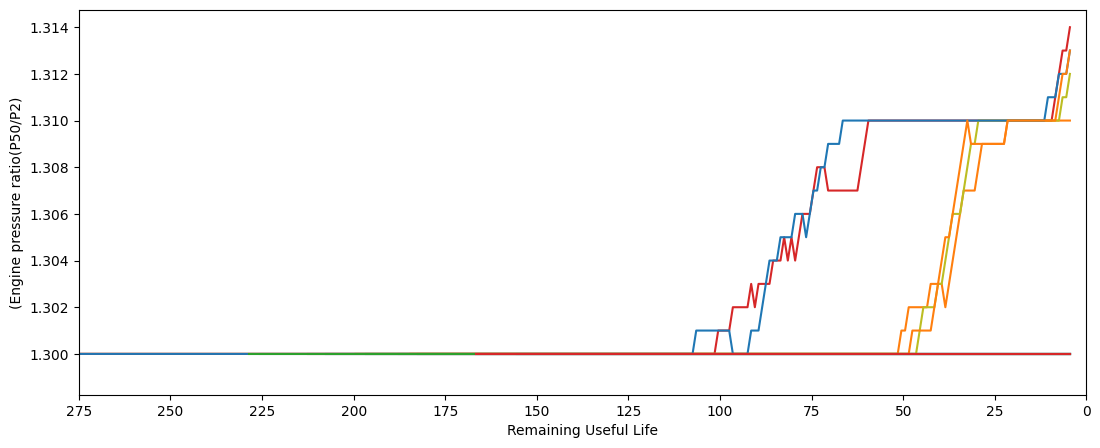

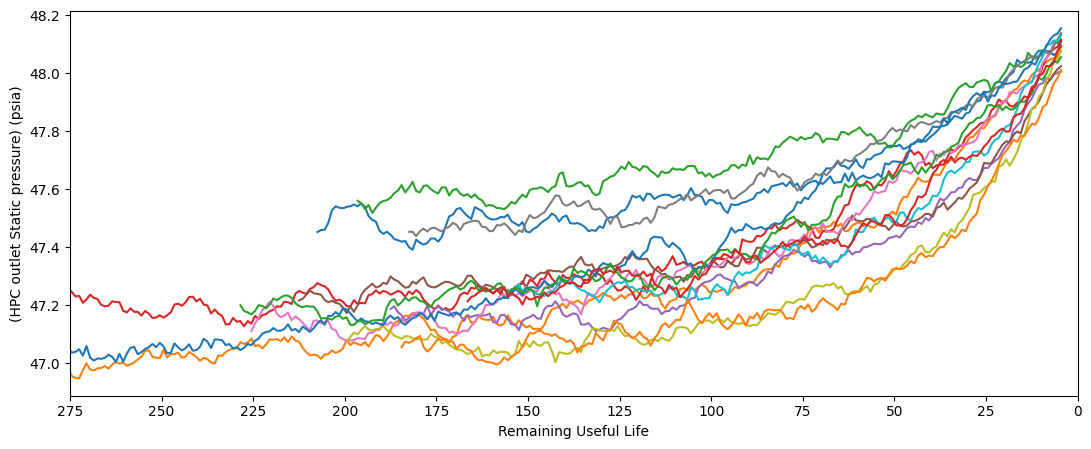

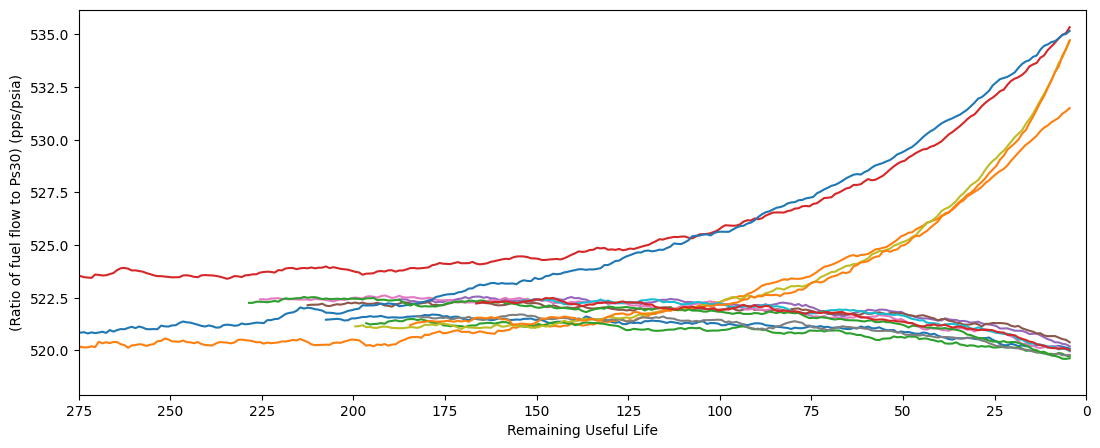

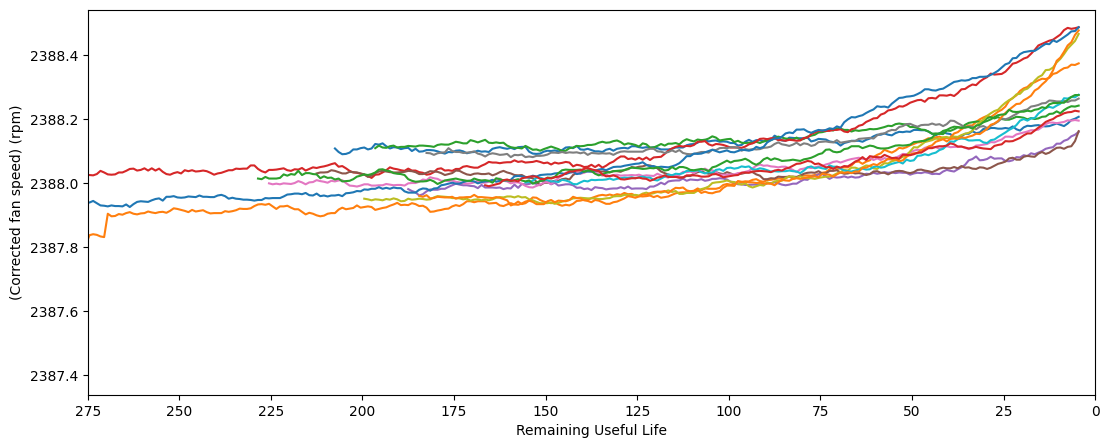

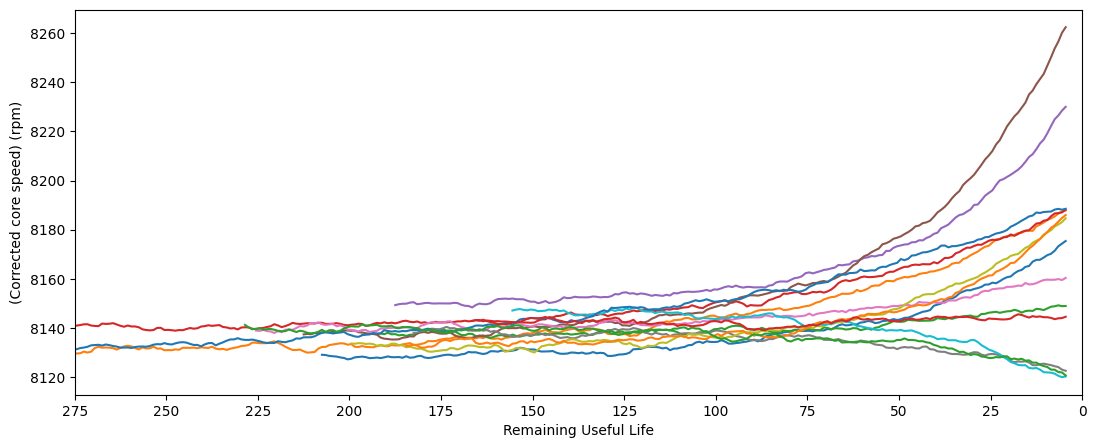

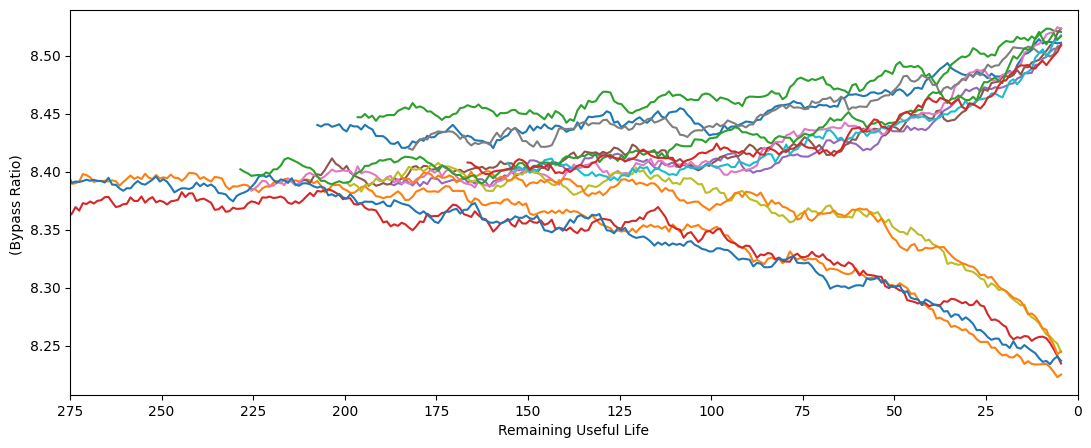

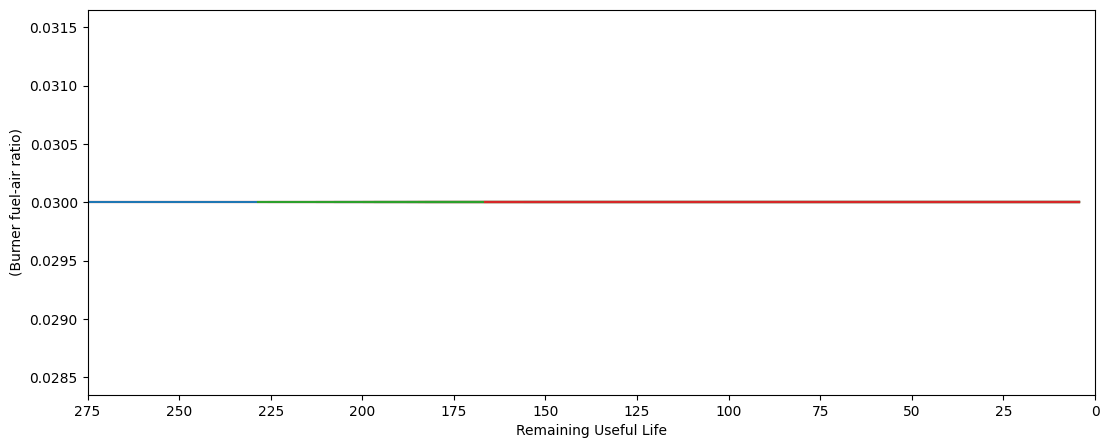

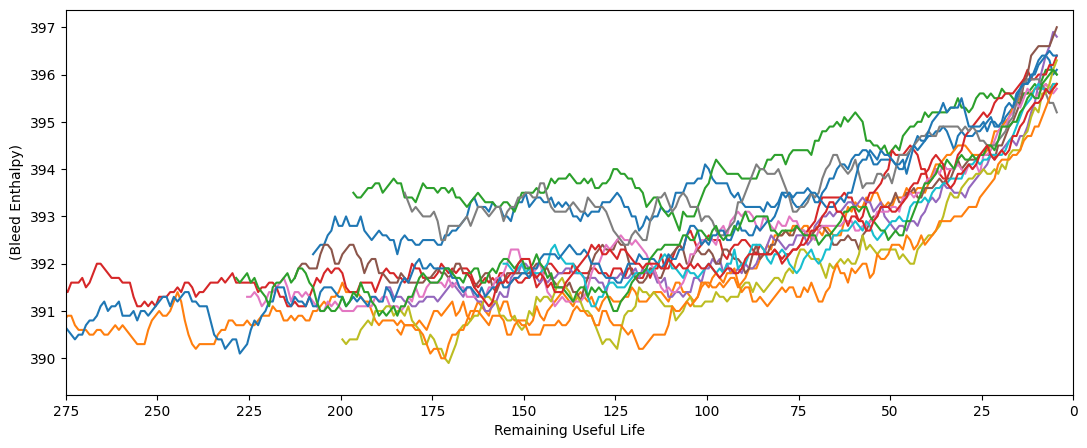

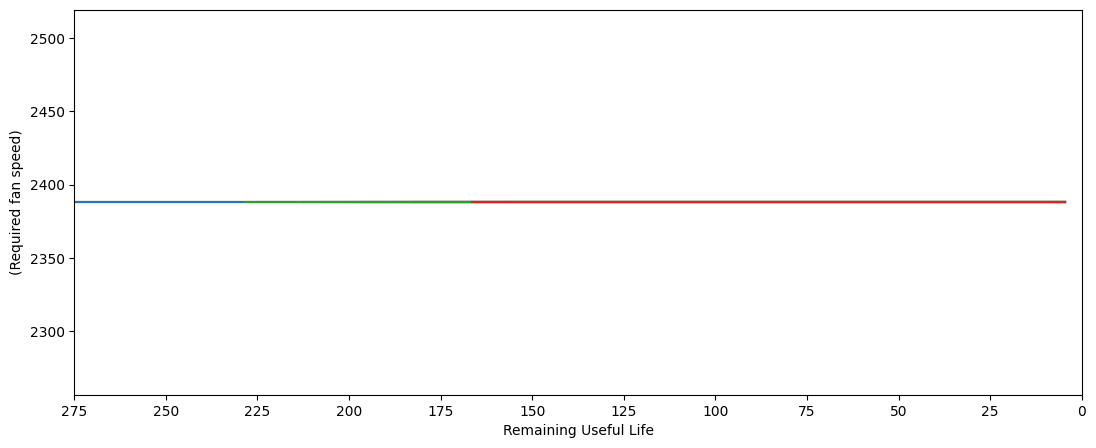

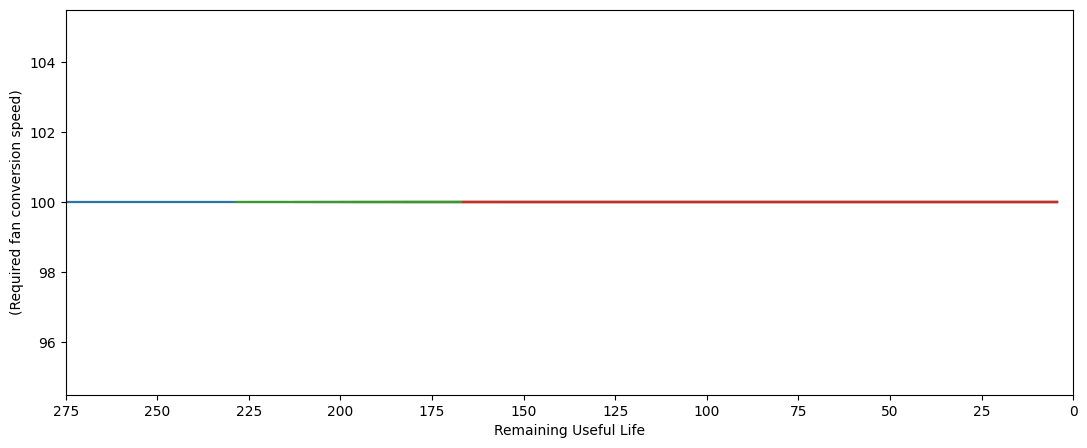

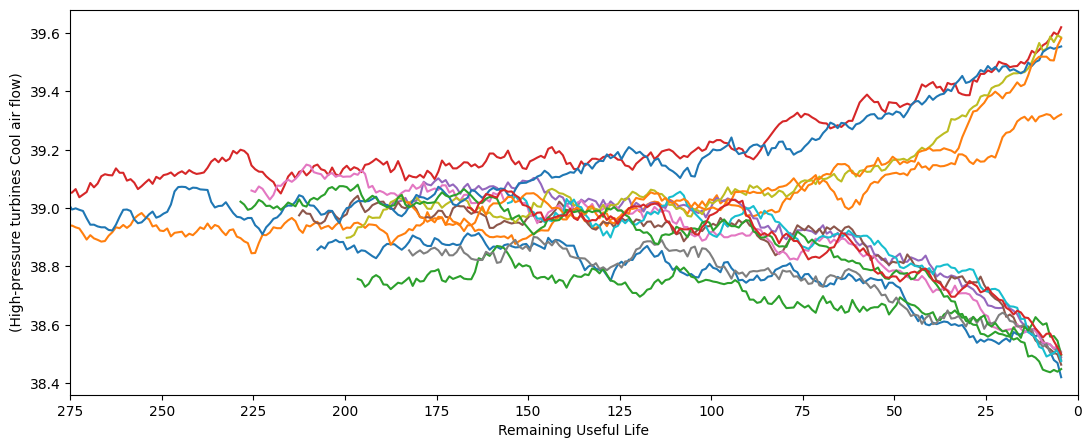

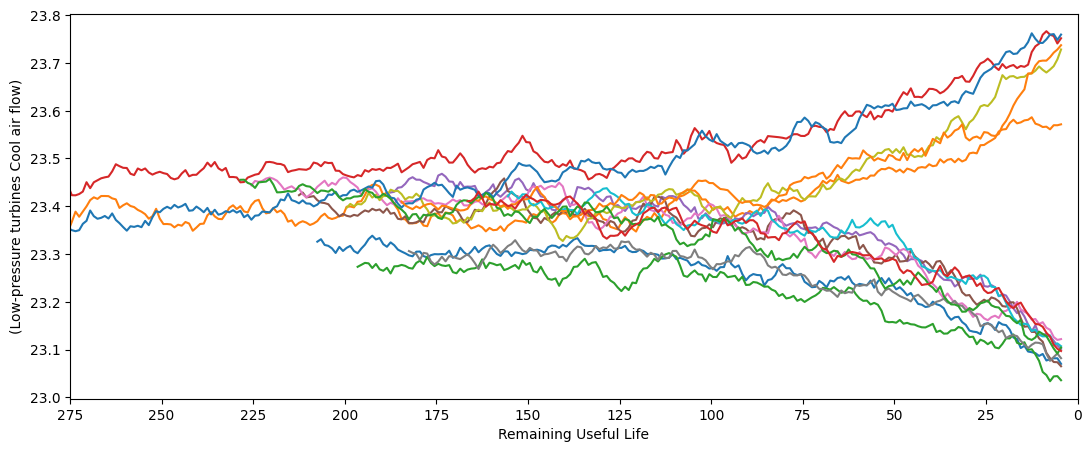

In [23]:
for i in range(1,22):
    try:
        plot_signal(train, Sensor_dictionary,'s_'+str(i))
    except:
        pass

In [24]:
train.loc[:,'s_1':].describe().transpose()

count         mean           std        min        25%        50%  \
s_1   17529.0   518.670000  0.000000e+00   518.6700   518.6700   518.6700   
s_2   17529.0   642.456737  5.277827e-01   640.8400   642.0700   642.4000   
s_3   17529.0  1588.052022  6.865455e+00  1564.3000  1583.2000  1587.4700   
s_4   17529.0  1404.441645  9.931666e+00  1377.0600  1396.9800  1402.8600   
s_5   17529.0    14.620000  3.552815e-15    14.6200    14.6200    14.6200   
s_6   17529.0    21.596744  1.884430e-02    21.4500    21.5800    21.6100   
s_7   17529.0   554.952255  3.348767e+00   549.6100   553.0400   553.9400   
s_8   17529.0  2388.067975  1.579436e-01  2386.9000  2388.0000  2388.0700   
s_9   17529.0  9063.767836  2.057996e+01  9021.9300  9051.1500  9059.3500   
s_10  17529.0     1.301115  3.348194e-03     1.2900     1.3000     1.3000   
s_11  17529.0    47.413785  3.027559e-01    46.6900    47.1900    47.3600   
s_12  17529.0   522.868619  3.169536e+00   517.7800   521.1000   521.8900   
s_13  17529.0  2388.068168  1.576391e-01  2386.9300  2388.0000  2388.0700   
s_14  17529.0  8143.900390  1.704635e+01  8102.9200  8133.8400  8140.5300   
s_15  17529.0     8.399658  5.949510e-02     8.1563     8.3664     8.4020   
s_16  17529.0     0.030000  1.387818e-17     0.0300     0.0300     0.0300   
s_17  17529.0   392.553654  1.776825e+00   388.0000   391.0000   392.0000   
s_18  17529.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
s_19  17529.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s_20  17529.0    38.975697  2.467082e-01    38.1700    38.8200    38.9700   
s_21  17529.0    23.385844  1.474839e-01    22.8995    23.2907    23.3835   
RUL   17529.0   139.180501  9.965508e+01     0.0000    62.0000   125.0000   

            75%        max  
s_1    518.6700   518.6700  
s_2    642.7900   645.1100  
s_3   1592.4500  1615.3900  
s_4   1410.7500  1441.1600  
s_5     14.6200    14.6200  
s_6     21.6100    21.6100  
s_7    555.6600   570.4900  
s_8   2388.1400  2388.6000  
s_9   9069.5100  9234.3500  
s_10     1.3000     1.3200  
s_11    47.6100    48.4400  
s_12   523.4800   537.4000  
s_13  2388.1400  2388.6100  
s_14  8148.7800  8290.5500  
s_15     8.4390     8.5705  
s_16     0.0300     0.0300  
s_17   394.0000   399.0000  
s_18  2388.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    39.1300    39.8400  
s_21    23.4737    23.9505  
RUL    190.0000   524.0000

MinMax scaler function : Transform features by scaling each feature to a given range.

This estimater scales and translates each feature individually such that it is in the given range on the training set

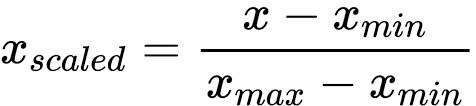

Dropping unnecessary features (labels and settings)

In [25]:
# 임시 코드
from sklearn.model_selection import train_test_split
drop_labels = index_names+setting_names

# index_name을 split해서 보관해뒀다가 추후에 병합해줘야 RL에 적용할 수 있음
X_train_index_names = train[['unit_number', 'time_cycles']]
X_train = train.drop(columns=drop_labels).copy()
X_train, X_test, y_train, y_test = train_test_split(X_train, X_train['RUL'], test_size = 0.01, random_state = 42, shuffle = False)

# Valid 코드도 수정해야 LR 가능함. ################################
# Valid data : engine 71~100
X_valid_index_names = valid[['unit_number','time_cycles']]
y_valid = valid[['RUL']]
X_valid = valid.drop(columns=drop_labels).copy()

X_full_index_names = full_data[['unit_number','time_cycles']]
y_full = full_data[['RUL']]
X_full = full_data.drop(columns=drop_labels).copy()

Test Code

In [26]:
print(y_train)
print(X_train)

0        258
1        257
2        256
3        255
4        254
        ... 
17348      8
17349      7
17350      6
17351      5
17352      4
Name: RUL, Length: 17353, dtype: int64
          s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8  \
0      518.67  642.36  1583.23  1396.84  14.62  21.61  553.97  2387.96   
1      518.67  642.50  1584.69  1396.89  14.62  21.61  554.55  2388.00   
2      518.67  642.18  1582.35  1405.61  14.62  21.61  554.43  2388.03   
3      518.67  642.92  1585.61  1392.27  14.62  21.61  555.21  2388.00   
4      518.67  641.68  1588.63  1397.65  14.62  21.61  554.74  2388.04   
...       ...     ...      ...      ...    ...    ...     ...      ...   
17348  518.67  643.23  1599.38  1423.46  14.62  21.61  552.22  2388.29   
17349  518.67  643.95  1593.56  1421.54  14.62  21.61  551.33  2388.30   
17350  518.67  643.42  1597.14  1423.75  14.62  21.61  551.06  2388.30   
17351  518.67  643.03  1597.15  1425.25  14.62  21.61  551.92  2388.26   
1735

In [27]:
print(y_valid)
print(X_valid)

      RUL
0     408
1     407
2     406
3     405
4     404
...   ...
7186    4
7187    3
7188    2
7189    1
7190    0

[7191 rows x 1 columns]
         s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8  \
0     518.67  642.08  1581.48  1400.26  14.62  21.57  551.28  2387.73   
1     518.67  641.52  1581.05  1394.00  14.62  21.57  551.46  2387.81   
2     518.67  641.70  1575.72  1390.85  14.62  21.58  553.04  2387.94   
3     518.67  642.02  1574.43  1396.86  14.62  21.57  550.62  2387.52   
4     518.67  642.30  1580.29  1395.08  14.62  21.57  551.09  2387.47   
...      ...     ...      ...      ...    ...    ...     ...      ...   
7186  518.67  643.78  1596.01  1424.11  14.62  21.61  551.86  2388.25   
7187  518.67  643.29  1596.38  1429.14  14.62  21.61  551.86  2388.23   
7188  518.67  643.84  1604.53  1431.41  14.62  21.61  551.30  2388.25   
7189  518.67  643.94  1597.56  1426.57  14.62  21.61  550.69  2388.26   
7190  518.67  643.64  1599.04  1436.06  14.62  21.61

Scaling the data

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()  # MinMaxScaler

#Droping the target variable (True RUL)
X_train.drop(columns=['RUL'], inplace=True) # inplace -> true면 원본 삭제 (current option)  # inplace -> False면 원본은 유지

#Scaling X_train
X_train_s=scaler.fit_transform(X_train)

#Conserve only the last occurence of each unit to match the length of y_valid
#X_valid = valid.groupby('unit_number').last().reset_index().drop(columns=drop_labels)

X_valid.drop(columns=['RUL'], inplace=True)
X_valid_s = scaler.transform(X_valid)

X_full.drop(columns=['RUL'], inplace=True)
X_full_s = scaler.transform(X_full)
#scaling X_valid
#X_valid_s=scaler.fit_transform(X_valid)

#fit_transform() : for train data ; transform() : for test data

In [29]:
print(X_train)

          s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8  \
0      518.67  642.36  1583.23  1396.84  14.62  21.61  553.97  2387.96   
1      518.67  642.50  1584.69  1396.89  14.62  21.61  554.55  2388.00   
2      518.67  642.18  1582.35  1405.61  14.62  21.61  554.43  2388.03   
3      518.67  642.92  1585.61  1392.27  14.62  21.61  555.21  2388.00   
4      518.67  641.68  1588.63  1397.65  14.62  21.61  554.74  2388.04   
...       ...     ...      ...      ...    ...    ...     ...      ...   
17348  518.67  643.23  1599.38  1423.46  14.62  21.61  552.22  2388.29   
17349  518.67  643.95  1593.56  1421.54  14.62  21.61  551.33  2388.30   
17350  518.67  643.42  1597.14  1423.75  14.62  21.61  551.06  2388.30   
17351  518.67  643.03  1597.15  1425.25  14.62  21.61  551.92  2388.26   
17352  518.67  643.76  1602.93  1429.21  14.62  21.61  551.35  2388.33   

           s_9  s_10  ...    s_12     s_13     s_14    s_15  s_16  s_17  s_18  \
0      9062.17   1.3  ...  522

In [30]:
print(X_train_s)

[[0.         0.3559719  0.37052261 ... 0.         0.56287425 0.43215985]
 [0.         0.38875878 0.39909963 ... 0.         0.49101796 0.52293054]
 [0.         0.31381733 0.3532981  ... 0.         0.40718563 0.44471931]
 ...
 [0.         0.60421546 0.64278724 ... 0.         0.16766467 0.16289248]
 [0.         0.51288056 0.64298297 ... 0.         0.16167665 0.23273073]
 [0.         0.68384075 0.75611666 ... 0.         0.28742515 0.15042816]]


In [31]:
print(X_valid_s.shape)
print(y_valid.shape)
print(X_valid)
print(X_valid_s)

(7191, 21)
(7191, 1)
         s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8  \
0     518.67  642.08  1581.48  1400.26  14.62  21.57  551.28  2387.73   
1     518.67  641.52  1581.05  1394.00  14.62  21.57  551.46  2387.81   
2     518.67  641.70  1575.72  1390.85  14.62  21.58  553.04  2387.94   
3     518.67  642.02  1574.43  1396.86  14.62  21.57  550.62  2387.52   
4     518.67  642.30  1580.29  1395.08  14.62  21.57  551.09  2387.47   
...      ...     ...      ...      ...    ...    ...     ...      ...   
7186  518.67  643.78  1596.01  1424.11  14.62  21.61  551.86  2388.25   
7187  518.67  643.29  1596.38  1429.14  14.62  21.61  551.86  2388.23   
7188  518.67  643.84  1604.53  1431.41  14.62  21.61  551.30  2388.25   
7189  518.67  643.94  1597.56  1426.57  14.62  21.61  550.69  2388.26   
7190  518.67  643.64  1599.04  1436.06  14.62  21.61  550.96  2388.26   

          s_9  s_10  ...    s_12     s_13     s_14    s_15  s_16  s_17  s_18  \
0     9037.91   1.3  .

In [32]:
print(y_valid)

      RUL
0     408
1     407
2     406
3     405
4     404
...   ...
7186    4
7187    3
7188    2
7189    1
7190    0

[7191 rows x 1 columns]


Plotting features new distribution

array([[<Axes: title={'center': 's_2'}>, <Axes: title={'center': 's_3'}>,
        <Axes: title={'center': 's_4'}>, <Axes: title={'center': 's_7'}>],
       [<Axes: title={'center': 's_8'}>, <Axes: title={'center': 's_9'}>,
        <Axes: title={'center': 's_11'}>,
        <Axes: title={'center': 's_12'}>],
       [<Axes: title={'center': 's_13'}>,
        <Axes: title={'center': 's_14'}>,
        <Axes: title={'center': 's_15'}>,
        <Axes: title={'center': 's_17'}>],
       [<Axes: title={'center': 's_20'}>,
        <Axes: title={'center': 's_21'}>, <Axes: >, <Axes: >]],
      dtype=object)

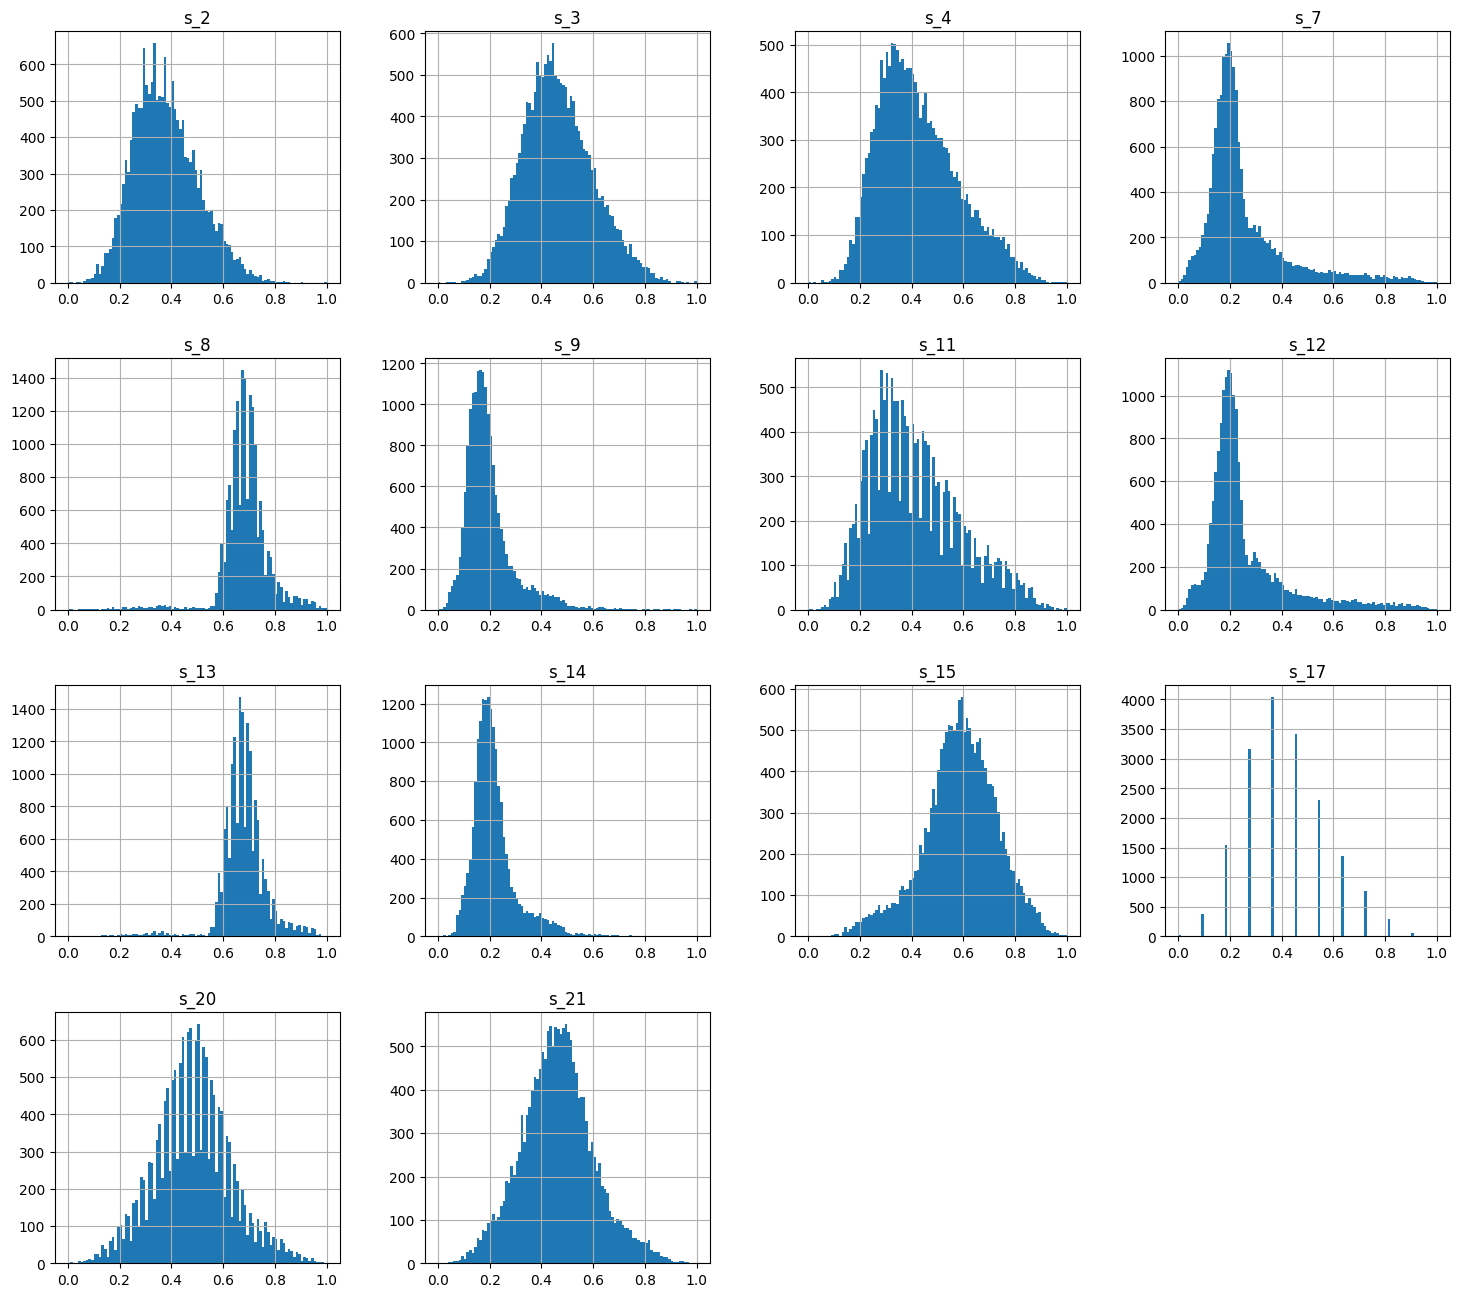

In [33]:
sensor_names=['s_{}'.format(i) for i in range(1,22) if i not in [1,5,6,10,16,18,19]]
pd.DataFrame(X_train_s,columns=['s_{}'.format(i) for i in range(1,22)])[sensor_names].hist(bins=100, figsize=(18,16))

# Model Implementation

Linear regression

In [34]:
"""
# 1. Original Linear Regression (gradient learning)
class Linear_Regression() :
    def __init__( self, lr=0.01, iterations=300 ) :
        self.lr = lr
        self.iterations = iterations
    def fit( self, X, Y ) :
        self.l, self.p = X.shape
        # weight initializer
        self.W = np.zeros( self.p ) # w : 0
        self.b = 0                  # b : 0
        self.X = X
        self.Y = Y
        # gradientlearning
        for i in range( self.iterations ) :
            self.weight_updater()
        return

    def weight_updater( self ) :
        Y_pred = self.predict( self.X )
        #  gradients
        dW = - ( 2 * ( self.X.T ).dot( self.Y - Y_pred )  ) / self.l
        db = - 2 * np.sum( self.Y - Y_pred ) / self.l
        # new weights assigned
        self.b = self.b - self.lr * db
        self.W = self.W - self.lr * dW
        return self

    def predict( self, X ) :
          # Y_pr=X.W+b
        return X.dot( self.W ) + self.b
"""

'\n# 1. Original Linear Regression (gradient learning)\nclass Linear_Regression() :\n    def __init__( self, lr=0.01, iterations=300 ) :\n        self.lr = lr\n        self.iterations = iterations\n    def fit( self, X, Y ) :\n        self.l, self.p = X.shape\n        # weight initializer\n        self.W = np.zeros( self.p ) # w : 0\n        self.b = 0                  # b : 0\n        self.X = X\n        self.Y = Y\n        # gradientlearning\n        for i in range( self.iterations ) :\n            self.weight_updater()\n        return\n\n    def weight_updater( self ) :\n        Y_pred = self.predict( self.X )\n        #  gradients\n        dW = - ( 2 * ( self.X.T ).dot( self.Y - Y_pred )  ) / self.l\n        db = - 2 * np.sum( self.Y - Y_pred ) / self.l\n        # new weights assigned\n        self.b = self.b - self.lr * db\n        self.W = self.W - self.lr * dW\n        return self\n\n    def predict( self, X ) :\n          # Y_pr=X.W+b\n        return X.dot( self.W ) + self.b\n'

Support Vector Regression (SVR)

In [35]:
from sklearn.svm import SVR
import tensorflow as tf
regressor = SVR(kernel='rbf')

Random forest

In [36]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)

Defining evaluation functions

In [37]:
# R2 score & RMSE & MSE
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat) # R2 score (R-squared) : indep. var.이 depend. var.을 얼마나 잘 설명하는가 (회귀모델 평가지표)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [38]:
# plot real data and the predicted one to make some comparison
def plot_predActual(y_test, y_test_hat):

    indices = np.arange(len(y_test_hat))
    wth= 0.6                                # width
    plt.figure(figsize=(70,30))
    true_values = [int(x) for x in y_test.values] # y : RUL
    predicted_values = list(y_test_hat)

    plt.bar(indices, true_values, width=wth,color='b', label='True RUL')
    plt.bar([i for i in indices], predicted_values, width=0.5*wth, color='r', alpha=0.7, label='Predicted RUL')

    plt.legend(prop={'size': 40})
    plt.tick_params(labelsize=40)

    plt.show()

**Use all feature**

In [39]:
print('maximum of y_train : ',y_train.max())
print('maximum of y_valid : ',y_valid.max())

maximum of y_train :  524
maximum of y_valid :  RUL    490
dtype: int64


In [40]:
print(X_train)

          s_1     s_2      s_3      s_4    s_5    s_6     s_7      s_8  \
0      518.67  642.36  1583.23  1396.84  14.62  21.61  553.97  2387.96   
1      518.67  642.50  1584.69  1396.89  14.62  21.61  554.55  2388.00   
2      518.67  642.18  1582.35  1405.61  14.62  21.61  554.43  2388.03   
3      518.67  642.92  1585.61  1392.27  14.62  21.61  555.21  2388.00   
4      518.67  641.68  1588.63  1397.65  14.62  21.61  554.74  2388.04   
...       ...     ...      ...      ...    ...    ...     ...      ...   
17348  518.67  643.23  1599.38  1423.46  14.62  21.61  552.22  2388.29   
17349  518.67  643.95  1593.56  1421.54  14.62  21.61  551.33  2388.30   
17350  518.67  643.42  1597.14  1423.75  14.62  21.61  551.06  2388.30   
17351  518.67  643.03  1597.15  1425.25  14.62  21.61  551.92  2388.26   
17352  518.67  643.76  1602.93  1429.21  14.62  21.61  551.35  2388.33   

           s_9  s_10  ...    s_12     s_13     s_14    s_15  s_16  s_17  s_18  \
0      9062.17   1.3  ...  522

(array([1470., 1470., 1468., 1065.,  709.,  458.,  284.,  151.,   66.,
          50.]),
 array([  0.,  49.,  98., 147., 196., 245., 294., 343., 392., 441., 490.]),
 <BarContainer object of 10 artists>)

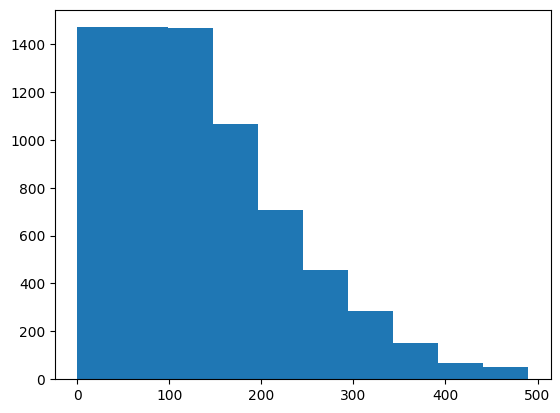

In [41]:
plt.hist(y_valid)

In [42]:
"""
drop_labels1=['s_1','s_2','s_5','s_6','s_8','s_9','s_10','s_11',
              's_13','s_14','s_15','s_16','s_17','s_18','s_19','s_20','s_21']
# drop -> axis : {0 or 'index', 1 or 'columns'}, default 0;
#         columns : axis (labels, axis = 1 is equivalent to index = labels)

# Drop labels
X_train_1=X_train.drop(columns=drop_labels1, axis=1) # drop the constant columns from the train dataset (because, axis = 1)
X_train_1_s=scaler.fit_transform(X_train_1) #scaling X_train_1

y_train_clip=y_train.clip(upper=195)  #Clipping y_train to have 195 as the maximum value (it means y = 197 -> y = 195)

X_valid_1=X_valid.drop(columns=drop_labels1, axis=1)  # drop the constant columns from the validation dataset
X_valid_1_s=scaler.fit_transform(X_valid_1) #scaling X_valid_1
"""

"\ndrop_labels1=['s_1','s_2','s_5','s_6','s_8','s_9','s_10','s_11',\n              's_13','s_14','s_15','s_16','s_17','s_18','s_19','s_20','s_21']\n# drop -> axis : {0 or 'index', 1 or 'columns'}, default 0;\n#         columns : axis (labels, axis = 1 is equivalent to index = labels)\n\n# Drop labels\nX_train_1=X_train.drop(columns=drop_labels1, axis=1) # drop the constant columns from the train dataset (because, axis = 1)\nX_train_1_s=scaler.fit_transform(X_train_1) #scaling X_train_1\n\ny_train_clip=y_train.clip(upper=195)  #Clipping y_train to have 195 as the maximum value (it means y = 197 -> y = 195)\n\nX_valid_1=X_valid.drop(columns=drop_labels1, axis=1)  # drop the constant columns from the validation dataset\nX_valid_1_s=scaler.fit_transform(X_valid_1) #scaling X_valid_1\n"

In [43]:
X_train_1=X_train
X_train_1_s=scaler.fit_transform(X_train_1) #scaling X_train_1

y_train_clip=y_train.clip(upper=195)  #Clipping y_train to have 195 as the maximum value (it means y = 197 -> y = 195)

X_valid_1=X_valid
X_valid_1_s=scaler.fit_transform(X_valid_1) #scaling X_valid_1

X_full_1=X_full
X_full_1_s=scaler.fit_transform(X_full_1) #scaling X_full_1


**Linear regression**

In [44]:
print(X_train_1_s)
print(X_train_1_s.shape)
print(X_valid_1_s)
print(X_valid_1_s.shape)
print(X_full_1_s)
print(X_full_1_s.shape)

[[0.         0.3559719  0.37052261 ... 0.         0.56287425 0.43215985]
 [0.         0.38875878 0.39909963 ... 0.         0.49101796 0.52293054]
 [0.         0.31381733 0.3532981  ... 0.         0.40718563 0.44471931]
 ...
 [0.         0.60421546 0.64278724 ... 0.         0.16766467 0.16289248]
 [0.         0.51288056 0.64298297 ... 0.         0.16167665 0.23273073]
 [0.         0.68384075 0.75611666 ... 0.         0.28742515 0.15042816]]
(17353, 21)
[[0.         0.3150289  0.30058585 ... 0.         0.40606061 0.3613388 ]
 [0.         0.15317919 0.2908968  ... 0.         0.41212121 0.40564012]
 [0.         0.20520231 0.17079766 ... 0.         0.38181818 0.47716628]
 ...
 [0.         0.82369942 0.81996395 ... 0.         0.11515152 0.19086651]
 [0.         0.85260116 0.66291122 ... 0.         0.06666667 0.19779469]
 [0.         0.76589595 0.69625958 ... 0.         0.21818182 0.20696721]]
(7191, 21)
[[0.         0.3559719  0.37052261 ... 0.         0.55952381 0.44633083]
 [0.         0.3

In [45]:
print(y_train_clip)
print(y_train_clip.shape)

0        195
1        195
2        195
3        195
4        195
        ... 
17348      8
17349      7
17350      6
17351      5
17352      4
Name: RUL, Length: 17353, dtype: int64
(17353,)


# **Loss function Tuning**

**1. Original MSE**

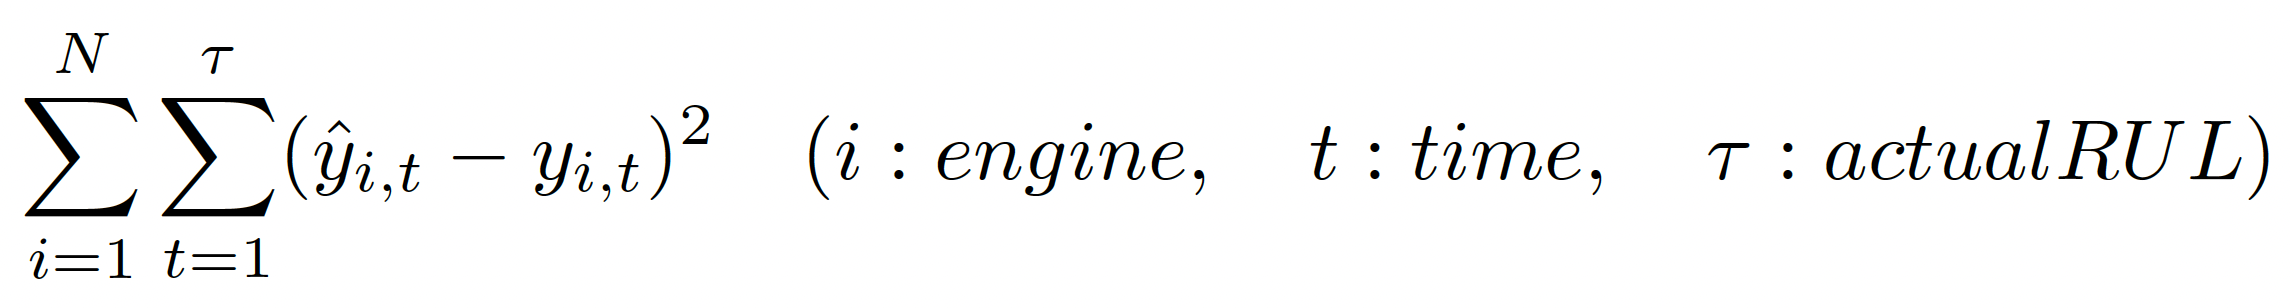

In [46]:
# 1. Original Linear Regression (모든 데이터 사용)
lr1 = LinearRegression()

lr1.fit(X_train_1_s, y_train_clip) #Fitting

y_lr_train_1 = lr1.predict(X_train_1_s) #Prediction on train data
evaluate(y_train_clip, y_lr_train_1, label='train')

y_lr_valid_1 = lr1.predict(X_valid_1_s) #Prediction on validation data
evaluate(y_valid, y_lr_valid_1, label='valid')

y_lr_full_1 = lr1.predict(X_full_1_s) #Prediction on full data
evaluate(y_full, y_lr_full_1, label='full data')

print(lr1.coef_)

train set RMSE:34.743533770016704, R2:0.7091587703254354
valid set RMSE:85.59234625850758, R2:0.2180809359431296
full data set RMSE:71.88398773747461, R2:0.4711192528525805
[ 0.00000000e+00 -3.95453399e+01 -3.39440407e+01 -6.47654621e+01
  4.26325641e-14  7.68570511e+01 -1.33099356e+01 -2.92912362e+01
 -9.17639084e+01 -3.06149893e+01 -8.31267600e+01 -3.51478671e+01
 -6.71724669e+01 -4.17813338e+01 -2.96772636e+01 -7.10542736e-15
 -3.11631077e+01  0.00000000e+00 -2.86985925e-42  3.66956217e+01
  2.86453991e+01]


**2. Crucial moments Loss function**

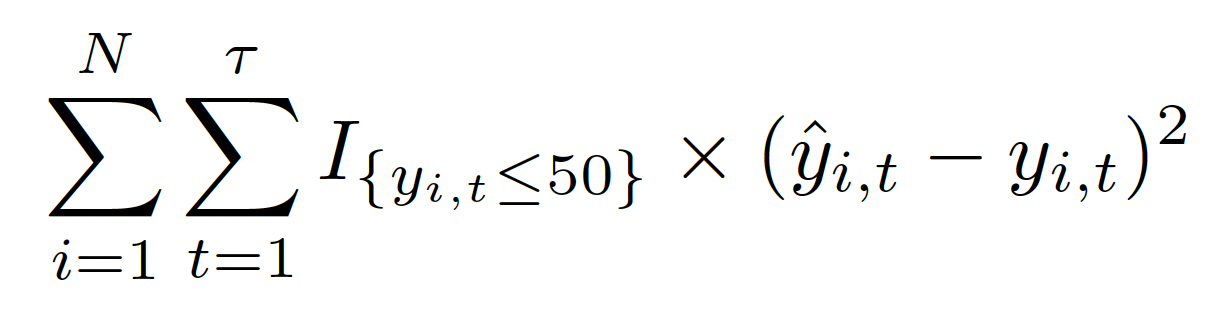

In [47]:
# 2. Crucial moments loss function - Linear Regression

# Filter and save only data that is less than 50.
filtered_data = X_train_1_s[y_train_clip <= 50]
filtered_labels = y_train_clip[y_train_clip <= 50]

lr2 = LinearRegression()

lr2.fit(filtered_data, filtered_labels) #Fitting

y_lr_train_2 = lr2.predict(X_train_1_s) #Prediction on train data
evaluate(y_train_clip, y_lr_train_2, label='train')

y_lr_valid_2 = lr2.predict(X_valid_1_s) #Prediction on validation data
evaluate(y_valid, y_lr_valid_2, label='valid')

y_lr_full_2 = lr2.predict(X_full_1_s) #Prediction on full data
evaluate(y_full, y_lr_full_2, label='full data')

print(lr2.coef_)

train set RMSE:83.37997602872144, R2:-0.6750644706004723
valid set RMSE:120.51014648450703, R2:-0.5500266590143807
full data set RMSE:121.1363282237674, R2:-0.5019042491153973
[ 0.00000000e+00 -7.95439227e+00 -8.66650105e+00 -1.57790014e+01
  8.88178420e-16  8.57208197e+00  2.80043562e+00 -4.82466080e+01
 -2.67289870e+01  4.90155222e-01 -2.45489924e+01 -2.32169455e+00
 -6.02261521e+01 -4.84968787e+00 -1.13735615e+01 -3.77475828e-15
 -7.06649263e+00  0.00000000e+00  0.00000000e+00  7.26755053e+00
  5.58250379e+00]


**3. TD Style Loss function (ridge regression)**

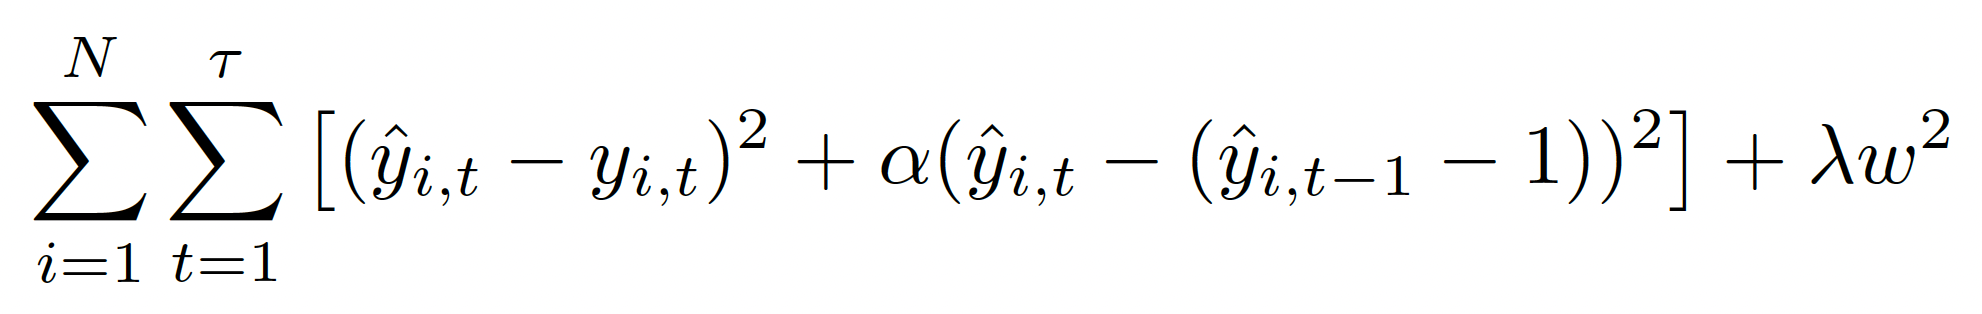

In [48]:
# Multi var linear regression

class Linear_Regression_TD() :
  def __init__( self, alpha=0, lambda_ridge=0 ) :
    self.alpha = alpha
    self.lambda_ridge = lambda_ridge  # Ridge regression

  def fit(self, X, Y, alpha, lambd) :
    self.l, self.p = X.shape
    self.alpha = alpha
    self.lambda_ridge = lambd
    # weight initializer
    self.p = (self.p + 1)         # add constant term.

    self.add_X = np.ones(self.l)
    self.X = np.c_[self.add_X, X]

    self.array_Y = np.array(Y[0:].to_numpy())
    self.array_Y.reshape( self.l, 1 )
    self.Y = self.array_Y
    self.W = np.zeros( self.p ) # W : 0 (b is included)

    self.identity = np.identity( n = self.p ) # Ridge regression
    self.lambda_identity = self.lambda_ridge * self.identity   # lambda * I

    # 각각의 행렬 연산
    X_T_X = (self.X.T) @ (self.X)          # X^(T)X
    X_diff_T_X_diff_sum = np.zeros( [self.p, self.p] )

    for i in range(1, self.l):
      X_diff_T_X_diff = (( self.X[i, :] - self.X[i - 1, :] ).reshape(self.p, 1)) @ (( self.X[i, :] - self.X[i - 1, :] ).reshape(1, self.p))
      X_diff_T_X_diff_sum += X_diff_T_X_diff


    X_T_Y = (self.X.T) @ (self.Y)
    X_T_Y = X_T_Y.reshape( self.p, 1 )
    X_diff_T_sum = np.zeros( [self.p, 1] )

    for i in range(1, self.l):
      X_diff_T = (( self.X[i, :] - self.X[i - 1, :] ).reshape( self.p, 1 ))
      X_diff_T_sum += X_diff_T

    self.W = np.linalg.inv(X_T_X + (self.alpha * X_diff_T_X_diff_sum) + self.lambda_identity) @ (X_T_Y - self.alpha * X_diff_T_sum)

    print(self.W)
    print(self.W.shape)

# X를 입력 받으면 첫 열에 1의 값을 갖는 열을 추가해서 계산해야함. (입력으로 들어오는 X는 (n, 21)이니 (n, 22)로 바꿔줘야 함)
  def predict( self, X) :
    l_X, p_X = X.shape
    p_X = p_X + 1
    add_col = np.ones(l_X)

    X = np.c_[add_col, X]

    return X.dot( self.W )

In [49]:
lr3 = Linear_Regression_TD()

# fit(X, Y, alpha, lambda)        # lambda = 10
lr3.fit(X_train_1_s, y_train_clip, 0.5, 10) #Fitting

y_lr_train_3 = lr3.predict(X_train_1_s) #Prediction on train data
evaluate(y_train_clip, y_lr_train_3, label='train')

y_lr_valid_3 = lr3.predict(X_valid_1_s) #Prediction on validation data
evaluate(y_valid, y_lr_valid_3, label='valid')

y_lr_full_3 = lr3.predict(X_full_1_s) #Prediction on full data
evaluate(y_full, y_lr_full_3, label='full data')

[[232.68688813]
 [  0.        ]
 [-35.77913831]
 [-29.57089368]
 [-60.082966  ]
 [  0.        ]
 [ 67.72114833]
 [-17.98683012]
 [-34.93754178]
 [-82.27821093]
 [-20.33764809]
 [-80.13871993]
 [-35.16452486]
 [-47.79665973]
 [-46.67971737]
 [-13.50424805]
 [  0.        ]
 [-30.87373201]
 [  0.        ]
 [  0.        ]
 [ 37.75327725]
 [ 36.5248926 ]]
(22, 1)
train set RMSE:34.94050994574411, R2:0.7058516115853535
valid set RMSE:85.24508939471171, R2:0.22441271601253354
full data set RMSE:72.95474629145836, R2:0.45524586209250595


**4. TD Style Loss function + Crucial moments (ridge regression)**

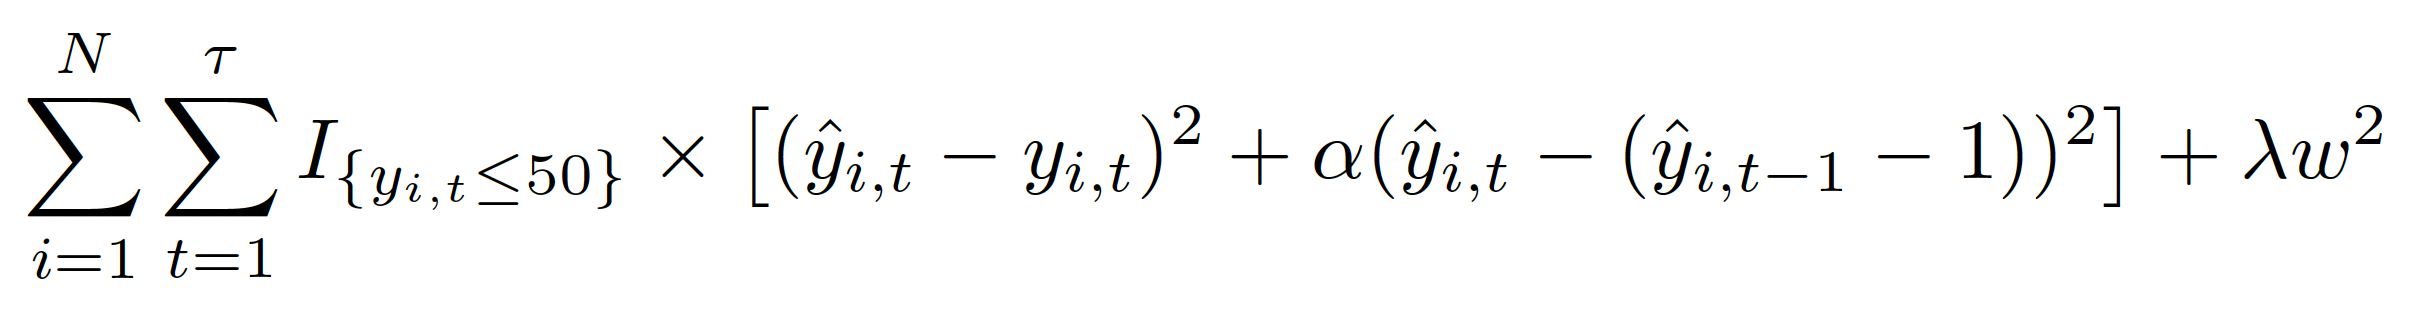

In [50]:
filtered_data_2 = X_train_1_s[y_train_clip <= 50]
filtered_labels_2 = y_train_clip[y_train_clip <= 50]

lr4 = Linear_Regression_TD()

# fit(X, Y, alpha, lambda)        # lambda = 10
lr4.fit(filtered_data_2, filtered_labels_2, 0.5, 10) #Fitting

y_lr_train_4 = lr4.predict(X_train_1_s)
evaluate(y_train_clip, y_lr_train_4, label='train')

y_lr_valid_4 = lr4.predict(X_valid_1_s) #Prediction on validation data
evaluate(y_valid, y_lr_valid_4, label='valid')

y_lr_full_4 = lr4.predict(X_full_1_s) #Prediction on full data
evaluate(y_full, y_lr_full_4, label='full data')


[[ 60.83230289]
 [  0.        ]
 [ -8.925354  ]
 [ -7.9142036 ]
 [-19.12563578]
 [  0.        ]
 [  9.39907031]
 [ -9.95146556]
 [ -0.76607774]
 [-11.69510289]
 [  3.40086951]
 [-26.3631238 ]
 [-12.619636  ]
 [ -3.15717937]
 [ -3.73576843]
 [  4.23719455]
 [  0.        ]
 [-10.23985783]
 [  0.        ]
 [  0.        ]
 [ 14.21037479]
 [ 13.07107597]]
(22, 1)
train set RMSE:92.60076401136907, R2:-1.0660324331380813
valid set RMSE:129.59737028085843, R2:-0.7926038189444786
full data set RMSE:130.2192572913746, R2:-0.7355769066694655


Merge!

In [51]:
# loss function 별 dataframe들을 list로 저장
y_lr_valid_dfs = [pd.DataFrame(y_lr_valid_1, columns=['predicted RUL']),
                  pd.DataFrame(y_lr_valid_2, columns=['predicted RUL']),
                  pd.DataFrame(y_lr_valid_3, columns=['predicted RUL']),
                  pd.DataFrame(y_lr_valid_4, columns=['predicted RUL'])]
merged_valid_dfs = []

# 각 dataframe에 병합하고 출력
for i, y_lr_valid_df in enumerate(y_lr_valid_dfs, start=1):
    merged_valid = pd.concat([X_valid_index_names, y_lr_valid_df, y_valid], axis=1)
    merged_valid_dfs.append(merged_valid)
    print(f"Merged Valid DataFrame {i}:\n", merged_valid)

Merged Valid DataFrame 1:
       unit_number  time_cycles  predicted RUL  RUL
0              71            1     143.452450  408
1              71            2     147.189427  407
2              71            3     149.301053  406
3              71            4     163.801960  405
4              71            5     169.337709  404
...           ...          ...            ...  ...
7186          100          148     -22.143225    4
7187          100          149     -15.653603    3
7188          100          150     -29.856526    2
7189          100          151     -14.448476    1
7190          100          152     -23.908414    0

[7191 rows x 4 columns]
Merged Valid DataFrame 2:
       unit_number  time_cycles  predicted RUL  RUL
0              71            1      80.720057  408
1              71            2      77.473662  407
2              71            3      71.704713  406
3              71            4      96.456458  405
4              71            5     104.159722  404
...

In [52]:
# loss function 별 dataframe들을 list로 저장
y_lr_full_dfs = [pd.DataFrame(y_lr_full_1, columns=['predicted RUL']),
                  pd.DataFrame(y_lr_full_2, columns=['predicted RUL']),
                  pd.DataFrame(y_lr_full_3, columns=['predicted RUL']),
                  pd.DataFrame(y_lr_full_4, columns=['predicted RUL'])]
merged_full_dfs = []

# 각 dataframe에 병합하고 출력
for i, y_lr_full_df in enumerate(y_lr_full_dfs, start=1):
    merged_full = pd.concat([X_full_index_names, y_lr_full_df, y_full], axis=1)
    merged_full_dfs.append(merged_full)
    print(f"Merged full DataFrame {i}:\n", merged_full)

Merged full DataFrame 1:
        unit_number  time_cycles  predicted RUL  RUL
0                1            1     153.109193  258
1                1            2     146.534939  257
2                1            3     142.365416  256
3                1            4     142.889074  255
4                1            5     155.809037  254
...            ...          ...            ...  ...
24715          100          148       6.078241    4
24716          100          149      11.692622    3
24717          100          150      -1.801913    2
24718          100          151      12.539794    1
24719          100          152       4.969771    0

[24720 rows x 4 columns]
Merged full DataFrame 2:
        unit_number  time_cycles  predicted RUL  RUL
0                1            1      63.236204  258
1                1            2      60.668288  257
2                1            3      59.922917  256
3                1            4      59.344023  255
4                1            5      6

# Visualization

**(1) 각 엔진의 online predict value (test data 71~100)**

(X-axis : Time cycles, Y-axis : predicted RUL)

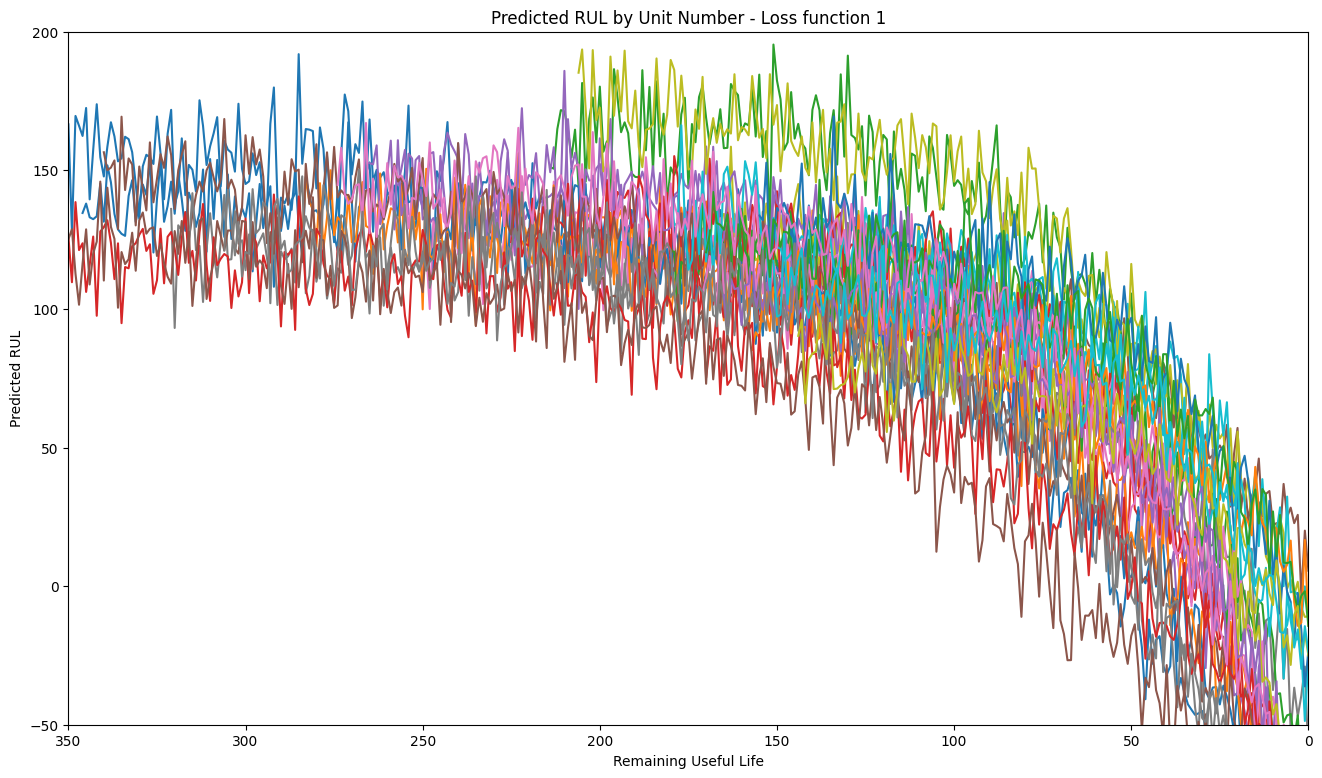

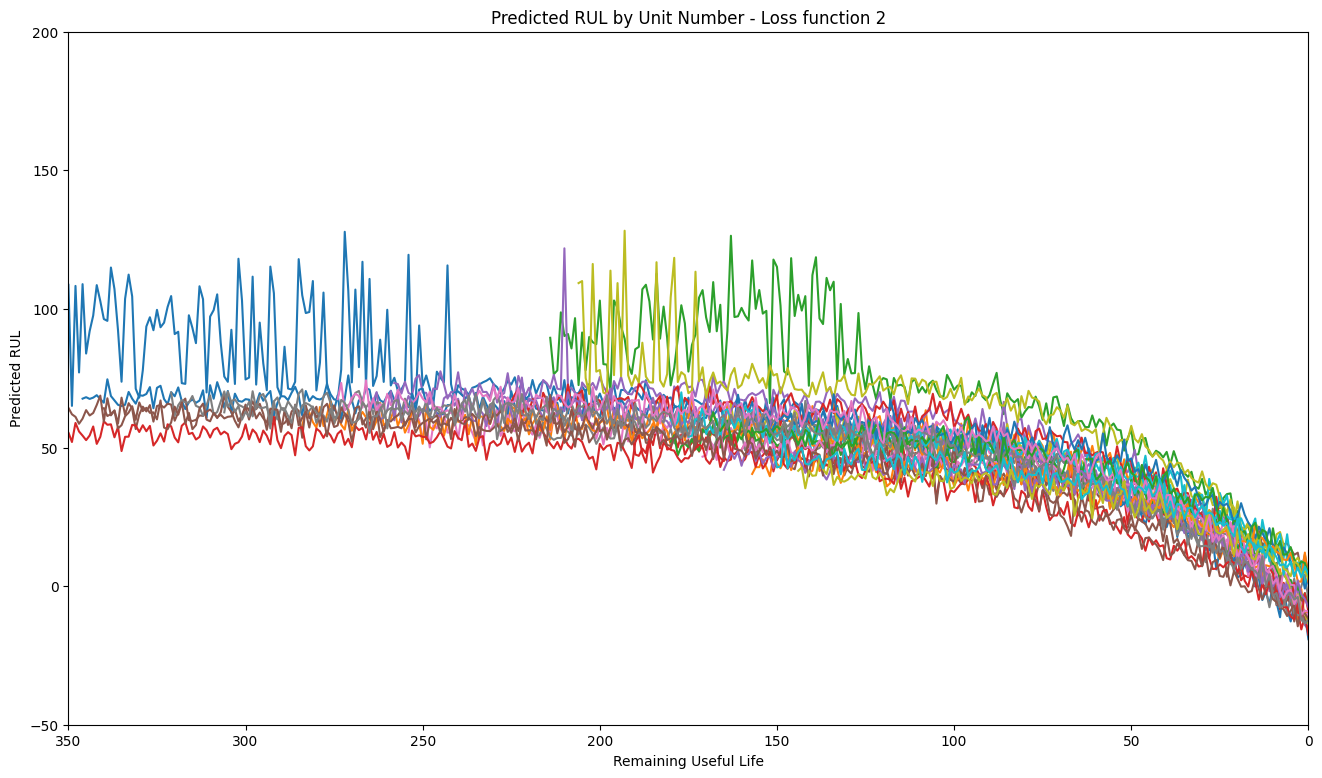

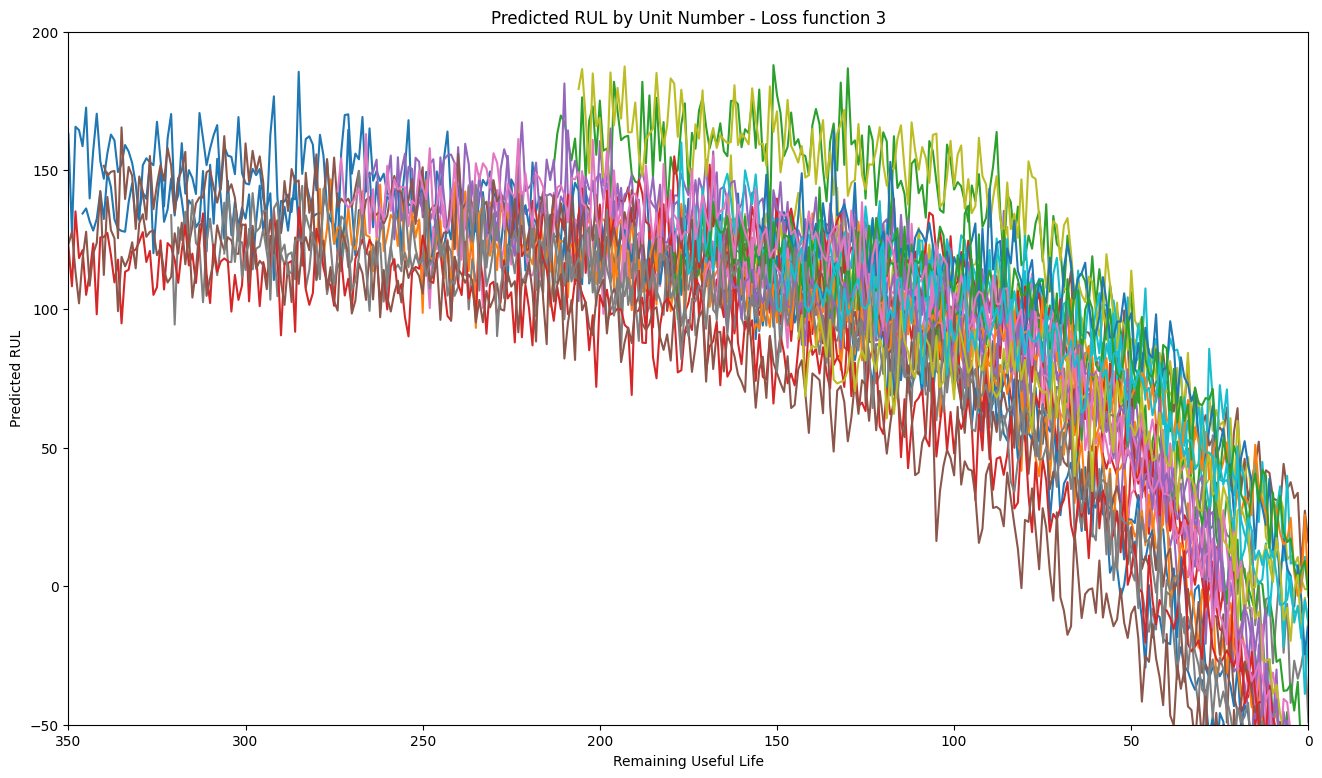

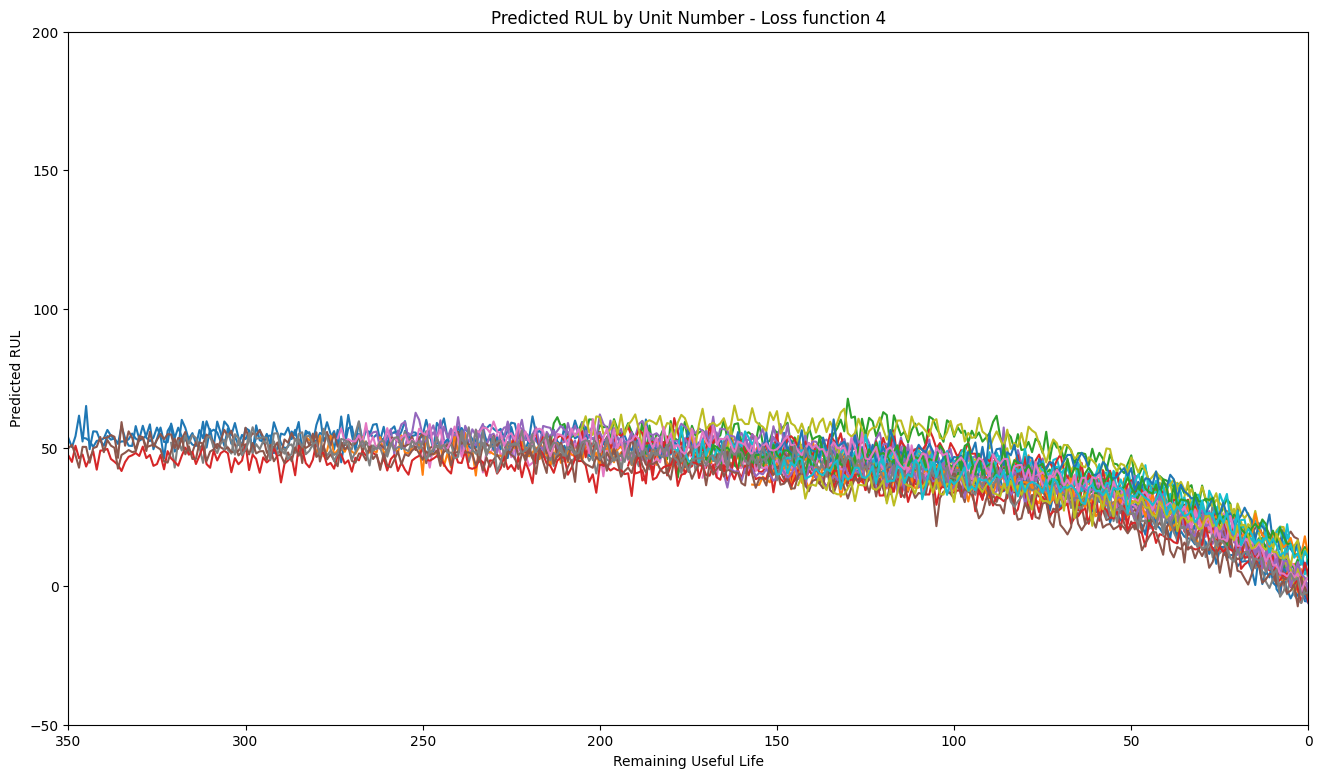

In [53]:
# merged_valid_dfs 리스트에 있는 데이터프레임들에 대해 반복 수행
for i, merged_valid_df in enumerate(merged_valid_dfs, start=1):
    # 데이터프레임에서 unit_number을 기준으로 그룹화
    grouped = merged_valid_df.groupby('unit_number')

    # 그래프를 그릴 subplot을 설정
    fig, ax = plt.subplots(figsize=(16, 9))

    # unit_number 별로 그래프 그리기
    for unit, group in grouped:
        ax.plot(group['RUL'], group['predicted RUL'], label=f'Unit {unit}')

    ax.set_xlabel('Remaining Useful Life')
    ax.set_ylabel('Predicted RUL')
    ax.set_title(f'Predicted RUL by Unit Number - Loss function {i}')
    #ax.legend(loc='upper right')  # 범례 추가

    # 그래프 출력 설정
    plt.xlim(350, 0)  # reverse the x-axis so RUL counts down to zero
    plt.ylim(-50, 200)
    plt.show()

**Threshold, Actual Operation Time**

**Add "Cumulative Operation Time", "Total Cost" Columns**


Cost : Failure (10,000), replace (1000)

In [54]:
# define list of threshold_value
threshold_start = -40        # -40
threshold_end = 90           # 90
threshold_values = list(range(threshold_start, threshold_end + 1))

# 각 threshold_value에 대한 dataframe을 담을 리스트를 생성.
by_threshold_dfs_list = []

# Define cost (Tentative Value)
REPLACE_COST = 1000       # replace cost를 크게 늘려도, 반등하는 최저점을 찾을 수 없음 <- Total cost로 해서 상수가 나왔었음. 시간당 cost로 환산하면 커브 그려짐.
FAILURE_COST = 10000

# merged_valid_dfs 리스트 내에 있는 각 데이터프레임에 대해 반복 수행

for merged_valid_df in merged_valid_dfs:
    by_threshold_dfs = []

    # threshold_value 별 처리.
    for threshold_value in threshold_values:

        cumulative_operation_time = 0
        total_cost = 0
        average_cost = 0             # total cost / operation time
        by_threshold_df = pd.DataFrame(columns=['unit_number', 'actual operation time', 'actual RUL', 'Cumulative Operation Time', 'Total Cost'])

        grouped = merged_valid_df.groupby('unit_number')

        for unit, group in grouped:
            operation_time = None

            max_RUL = group['RUL'].max()

            for index, row in group.iterrows():
                if row['predicted RUL'] <= threshold_value:   # 'predicted RUL'이 threshold보다 작거나 같으면 replace! (이후 for문 탈출)
                    operation_time = row['time_cycles']
                    cumulative_operation_time += operation_time
                    total_cost += REPLACE_COST
                    break


            if pd.isna(operation_time):
                cumulative_operation_time += max_RUL
                total_cost += FAILURE_COST

            average_cost = total_cost / cumulative_operation_time  # calculate average cost
            by_threshold_df = by_threshold_df.append({'unit_number': unit, 'actual operation time': operation_time,
                                                      'actual RUL': max_RUL, 'Cumulative Operation Time': cumulative_operation_time,
                                                      'Average Cost' : average_cost, 'Total Cost': total_cost}, ignore_index=True)

        by_threshold_dfs.append(by_threshold_df)

    by_threshold_dfs_list.append(by_threshold_dfs)

**Apply full data set**

In [ ]:
# 각 threshold_value에 대한 dataframe을 담을 리스트를 생성.
full_by_threshold_dfs_list = []

# merged_full_dfs 리스트 내에 있는 각 데이터프레임에 대해 반복 수행
for merged_full_df in merged_full_dfs:
    full_by_threshold_dfs = []

    # threshold_value 별 처리.
    for threshold_value in threshold_values:

        cumulative_operation_time = 0
        total_cost = 0
        average_cost = 0             # total cost / operation time
        full_by_threshold_df = pd.DataFrame(columns=['unit_number', 'actual operation time', 'actual RUL', 'Cumulative Operation Time', 'Total Cost'])

        grouped = merged_full_df.groupby('unit_number')

        for unit, group in grouped:
            operation_time = None

            max_RUL = group['RUL'].max()

            for index, row in group.iterrows():
                if row['predicted RUL'] <= threshold_value:
                    operation_time = row['time_cycles']
                    cumulative_operation_time += operation_time
                    total_cost += REPLACE_COST
                    break

            if pd.isna(operation_time):
                cumulative_operation_time += max_RUL
                total_cost += FAILURE_COST

            average_cost = total_cost / cumulative_operation_time  # calculate average cost
            full_by_threshold_df = full_by_threshold_df.append({'unit_number': unit, 'actual operation time': operation_time,
                                                      'actual RUL': max_RUL, 'Cumulative Operation Time': cumulative_operation_time,
                                                      'Average Cost' : average_cost, 'Total Cost': total_cost}, ignore_index=True)

        full_by_threshold_dfs.append(full_by_threshold_df)

    full_by_threshold_dfs_list.append(full_by_threshold_dfs)
#print(full_by_threshold_dfs_list[1][1])

In [ ]:
#print(full_by_threshold_dfs_list[1][1])
#print(full_by_threshold_dfs_list[2][1])

**(2) Threshold를 x축으로 두고 분석**

(x-axis : Threshold, y-axis : Number of replace failures)


(x-axis : Threshold, y-axis : Total Cost)

In [ ]:
# Total time을 고정하는 것이 아닌, 사용한 엔진 수를 고정해 비교. (23.09.09)

# empty list를 생성, threshold와 count of NaN을 저장할 list 초기화.
# 정해진 operation time까지의 Total Cost를 저장할 list 초기화.
nan_counts_list = []
average_cost_list_list = []
average_usage_time_list_list = []

# 각 by_threshold_dfs 리스트 내의 by_threshold_df에 대해 반복 수행
for by_threshold_dfs in by_threshold_dfs_list:
    nan_counts = []
    average_cost_list = []
    average_usage_time_list = []

    # 각 dataframe마다 수행.
    for df in by_threshold_dfs:

        average_usage_time = df['Cumulative Operation Time'].iloc[-1] / (len(df.index) + 1)  # 전체 엔진에 대한 평균 사용 시간 저장.
        average_usage_time_list.append(average_usage_time)                                   # 결과를 리스트에 다시 저장.


        average_cost_by_threshold = df['Average Cost'].iloc[-1]                                  # 'Average Cost'의 열에서 마지막 값을 가져옴.
        average_cost_list.append(average_cost_by_threshold)                                      # 'Average Cost'를 list에 저장

        # 'actual operation time' column의 NaN 개수 count 후 리스트에 추가. index의 끝까지 Nan을 count.
        nan_count = df.loc[:, 'actual operation time'].isna().sum()
        nan_counts.append(nan_count)

    nan_counts_list.append(nan_counts)
    average_cost_list_list.append(average_cost_list)
    average_usage_time_list_list.append(average_usage_time_list)

# 각 by_threshold_dfs 리스트 내에 대한 결과를 저장하는 데이터프레임 생성
nan_counts_and_cost_df_list = []
for i, by_threshold_dfs in enumerate(by_threshold_dfs_list, start=1):
    threshold_values = list(range(threshold_start, threshold_end + 1))
    nan_counts_and_cost_df = pd.DataFrame({'Threshold': threshold_values, 'Number of replace failures': nan_counts_list[i - 1],
                                           'Average Cost': average_cost_list_list[i - 1], 'Average usage time' : average_usage_time_list_list[i - 1]})
    nan_counts_and_cost_df_list.append(nan_counts_and_cost_df)
    print(f"DataFrame for merged_valid_df {i}:\n", nan_counts_and_cost_df)

**apply full data**

In [ ]:
# Total time을 고정하는 것이 아닌, 사용한 엔진 수를 고정해 비교. (23.09.09)

# empty list를 생성, threshold와 count of NaN을 저장할 list 초기화.
# 정해진 operation time까지의 Total Cost를 저장할 list 초기화.
full_nan_counts_list = []
full_average_cost_list_list = []
full_average_usage_time_list_list = []

# 각 by_threshold_dfs 리스트 내의 by_threshold_df에 대해 반복 수행
for full_by_threshold_dfs in full_by_threshold_dfs_list:
    full_nan_counts = []
    full_average_cost_list = []
    full_average_usage_time_list = []

    # 각 dataframe마다 수행.
    for df in full_by_threshold_dfs:

        full_average_usage_time = df['Cumulative Operation Time'].iloc[-1] / (len(df.index) + 1)  # 전체 엔진에 대한 평균 사용 시간 저장.
        full_average_usage_time_list.append(full_average_usage_time)                                   # 결과를 리스트에 다시 저장.


        full_average_cost_by_threshold = df['Average Cost'].iloc[-1]                            # 'Average Cost'의 열에서 마지막 값을 가져옴.
        full_average_cost_list.append(full_average_cost_by_threshold)                           # 'Aberage cost'를 list에 저장

        # 'actual operation time' column의 NaN 개수 count 후 리스트에 추가. index의 끝까지 Nan을 count.
        full_nan_count = df.loc[:, 'actual operation time'].isna().sum()
        full_nan_counts.append(full_nan_count)

    full_nan_counts_list.append(full_nan_counts)
    full_average_cost_list_list.append(full_average_cost_list)
    full_average_usage_time_list_list.append(full_average_usage_time_list)

# 각 by_threshold_dfs 리스트 내에 대한 결과를 저장하는 데이터프레임 생성
full_nan_counts_and_cost_df_list = []
for i, full_by_threshold_dfs in enumerate(full_by_threshold_dfs_list, start=1):
    threshold_values = list(range(threshold_start, threshold_end + 1))
    full_nan_counts_and_cost_df = pd.DataFrame({'Threshold': threshold_values, 'Number of replace failures': full_nan_counts_list[i - 1],
                                           'Total Cost': full_average_cost_list_list[i - 1], 'Average usage time' : full_average_usage_time_list_list[i - 1]})
    full_nan_counts_and_cost_df_list.append(full_nan_counts_and_cost_df)
    print(f"DataFrame for merged_valid_df {i}:\n", full_nan_counts_and_cost_df)

**Scatter plot - Threshold에 따른 replace 실패 횟수와, 총 사용한 엔진수**

In [ ]:
"""
fig, axs = plt.subplots(len(nan_counts_and_cost_df_list), 1, figsize=(10, 6*len(nan_counts_and_cost_df_list)))

# 데이터프레임들을 저장한 리스트인 nan_counts_and_cost_df_list 내의 각 데이터프레임에 대해 반복 수행
for i, nan_counts_and_cost_df in enumerate(nan_counts_and_cost_df_list, start=1):
    ax1 = axs[i-1]

    # 왼쪽 Y축 그래프 (Number of failures)
    color = 'tab:blue'
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Number of replace failures', color=color)
    ax1.scatter(nan_counts_and_cost_df['Threshold'], nan_counts_and_cost_df['Number of replace failures'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax1.set_ylim(-5,80)

    # 오른쪽 Y축 그래프 (Total Number of Engines Used)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Total Number of Engines Used', color=color)
    ax2.scatter(nan_counts_and_cost_df['Threshold'], nan_counts_and_cost_df['Last index'] + 1, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax2.set_ylim(10,140)

    # 그래프 제목 설정
    ax1.set_title(f'Number of Failures & Total Number of Engines Used - Loss function {i}')

# 그래프 보이기
plt.tight_layout()  # subplot 간격 조정
plt.show()
"""

**Plot - Threshold에 따른 replace 실패 횟수와, 총 사용한 엔진 수**

In [ ]:
"""
fig, axs = plt.subplots(len(nan_counts_and_cost_df_list), 1, figsize=(10, 6*len(nan_counts_and_cost_df_list)))

# 데이터프레임들을 저장한 리스트인 nan_counts_and_cost_df_list 내의 각 데이터프레임에 대해 반복 수행
for i, nan_counts_and_cost_df in enumerate(nan_counts_and_cost_df_list, start=1):
    ax1 = axs[i-1]

    # 왼쪽 Y축 그래프 (Number of failures)
    color = 'tab:blue'
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Number of replace failures', color=color)
    ax1.plot(nan_counts_and_cost_df['Threshold'], nan_counts_and_cost_df['Number of replace failures'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax1.set_ylim(-5,80)

    # 오른쪽 Y축 그래프 (Total Number of Engines Used)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Total Number of Engines Used', color=color)
    ax2.plot(nan_counts_and_cost_df['Threshold'], nan_counts_and_cost_df['Last index'] + 1, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax2.set_ylim(10,140)

    # 그래프 제목 설정
    ax1.set_title(f'Number of Failures & Total Number of Engines Used - Loss function {i}')

# 그래프 보이기
plt.tight_layout()  # subplot 간격 조정
plt.show()
"""

**Scatter plot - Total Cost & Total Number of Engines Used**

In [ ]:
"""
fig, axs = plt.subplots(len(nan_counts_and_cost_df_list), 1, figsize=(10, 6*len(nan_counts_and_cost_df_list)))

# 데이터프레임들을 저장한 리스트인 nan_counts_and_cost_df_list 내의 각 데이터프레임에 대해 반복 수행
for i, nan_counts_and_cost_df in enumerate(nan_counts_and_cost_df_list, start=1):
    ax1 = axs[i-1]

    # 왼쪽 Y축 그래프 (Number of failures)
    color = 'tab:green'
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Total Cost', color=color)
    ax1.scatter(nan_counts_and_cost_df['Threshold'], nan_counts_and_cost_df['Total Cost'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax1.set_ylim(-5000,250000)

    # 오른쪽 Y축 그래프 (Total Number of Engines Used)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Total Number of Engines Used', color=color)
    ax2.scatter(nan_counts_and_cost_df['Threshold'], nan_counts_and_cost_df['Last index'] + 1, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax2.set_ylim(20,32)

    # 그래프 제목 설정
    ax1.set_title(f'Total Cost & Total Number of Engines Used - Loss function {i}')

# 그래프 보이기
plt.tight_layout()  # subplot 간격 조정
plt.show()
"""

**Plot - Total Cost & Total Number of Engines Used**

In [ ]:
"""
fig, axs = plt.subplots(len(nan_counts_and_cost_df_list), 1, figsize=(10, 6*len(nan_counts_and_cost_df_list)))

# 데이터프레임들을 저장한 리스트인 nan_counts_and_cost_df_list 내의 각 데이터프레임에 대해 반복 수행
for i, nan_counts_and_cost_df in enumerate(nan_counts_and_cost_df_list, start=1):
    ax1 = axs[i-1]

    # 왼쪽 Y축 그래프 (Total Cost)
    color = 'tab:green'
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Total Cost', color=color)
    ax1.plot(nan_counts_and_cost_df['Threshold'], nan_counts_and_cost_df['Total Cost'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax1.set_ylim(-5000,250000)

    # 오른쪽 Y축 그래프 (Total Number of Engines Used)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Total Number of Engines Used', color=color)
    ax2.plot(nan_counts_and_cost_df['Threshold'], nan_counts_and_cost_df['Last index'] + 1, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax2.set_ylim(20,32)

    # 그래프 제목 설정
    ax1.set_title(f'Total Cost & Total Number of Engines Used - Loss function {i}')

# 그래프 보이기
plt.tight_layout()  # subplot 간격 조정
plt.show()
"""

**Scatter plot of Total Cost**

In [ ]:
"""
for i, nan_counts_and_cost_df in enumerate(nan_counts_and_cost_df_list, start=1):
    plt.scatter(nan_counts_and_cost_df['Threshold'], nan_counts_and_cost_df['Total Cost'])
    plt.xlabel('Threshold')
    plt.ylabel('Total Cost')
    plt.title(f'Threshold vs Total Cost - Loss function {i}')
    plt.grid(True)
    plt.ylim(-5000, 1010000)
    plt.show()
"""

**Plot of Total Cost**

In [ ]:
"""
for i, nan_counts_and_cost_df in enumerate(nan_counts_and_cost_df_list, start=1):
    plt.plot(nan_counts_and_cost_df['Threshold'], nan_counts_and_cost_df['Total Cost'])
    plt.xlabel('Threshold')
    plt.ylabel('Total Cost')
    plt.title(f'Threshold vs Total Cost - Loss function {i}')
    plt.grid(True)
    plt.ylim(-100, 70000)
    plt.show()
"""

**Valid Data로 나타낸 (Number of Failures vs. Number of Engine used)**

In [ ]:
"""
from matplotlib.ticker import MaxNLocator

# Create a list of colors for each dataframe
colors = ['blue', 'green', 'red', 'yellow']

fig, ax = plt.subplots(figsize=(10, 6))

# Loop through the dataframes and plot scatter points with different colors
for i, nan_counts_and_cost_df in enumerate(nan_counts_and_cost_df_list):
    ax.scatter(
        nan_counts_and_cost_df['Number of replace failures'],
        nan_counts_and_cost_df['Last index'] + 1,
        label=f'Loss function {i + 1}',
        color=colors[i]
    )

# Set labels and title
ax.set_xlabel('Number of replace failures')
ax.set_ylabel('Total Number of Engines Used')
ax.set_title('Number of Failures vs. Total Number of Engines Used')

# Add legend
ax.legend()

# Set integer ticks for y-axes
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylim(-0.5,32)
ax.set_xlim(-0.5,32)


# Set aspect ratio to make the plot square
ax.set_aspect('equal')

# Show the plot
plt.tight_layout()
plt.show()
"""

**여기부터 average usage time 적용!**

**Scatter plot - Threshold에 따른 replace 실패 횟수와, 엔진 평균 사용시간 - Full data**

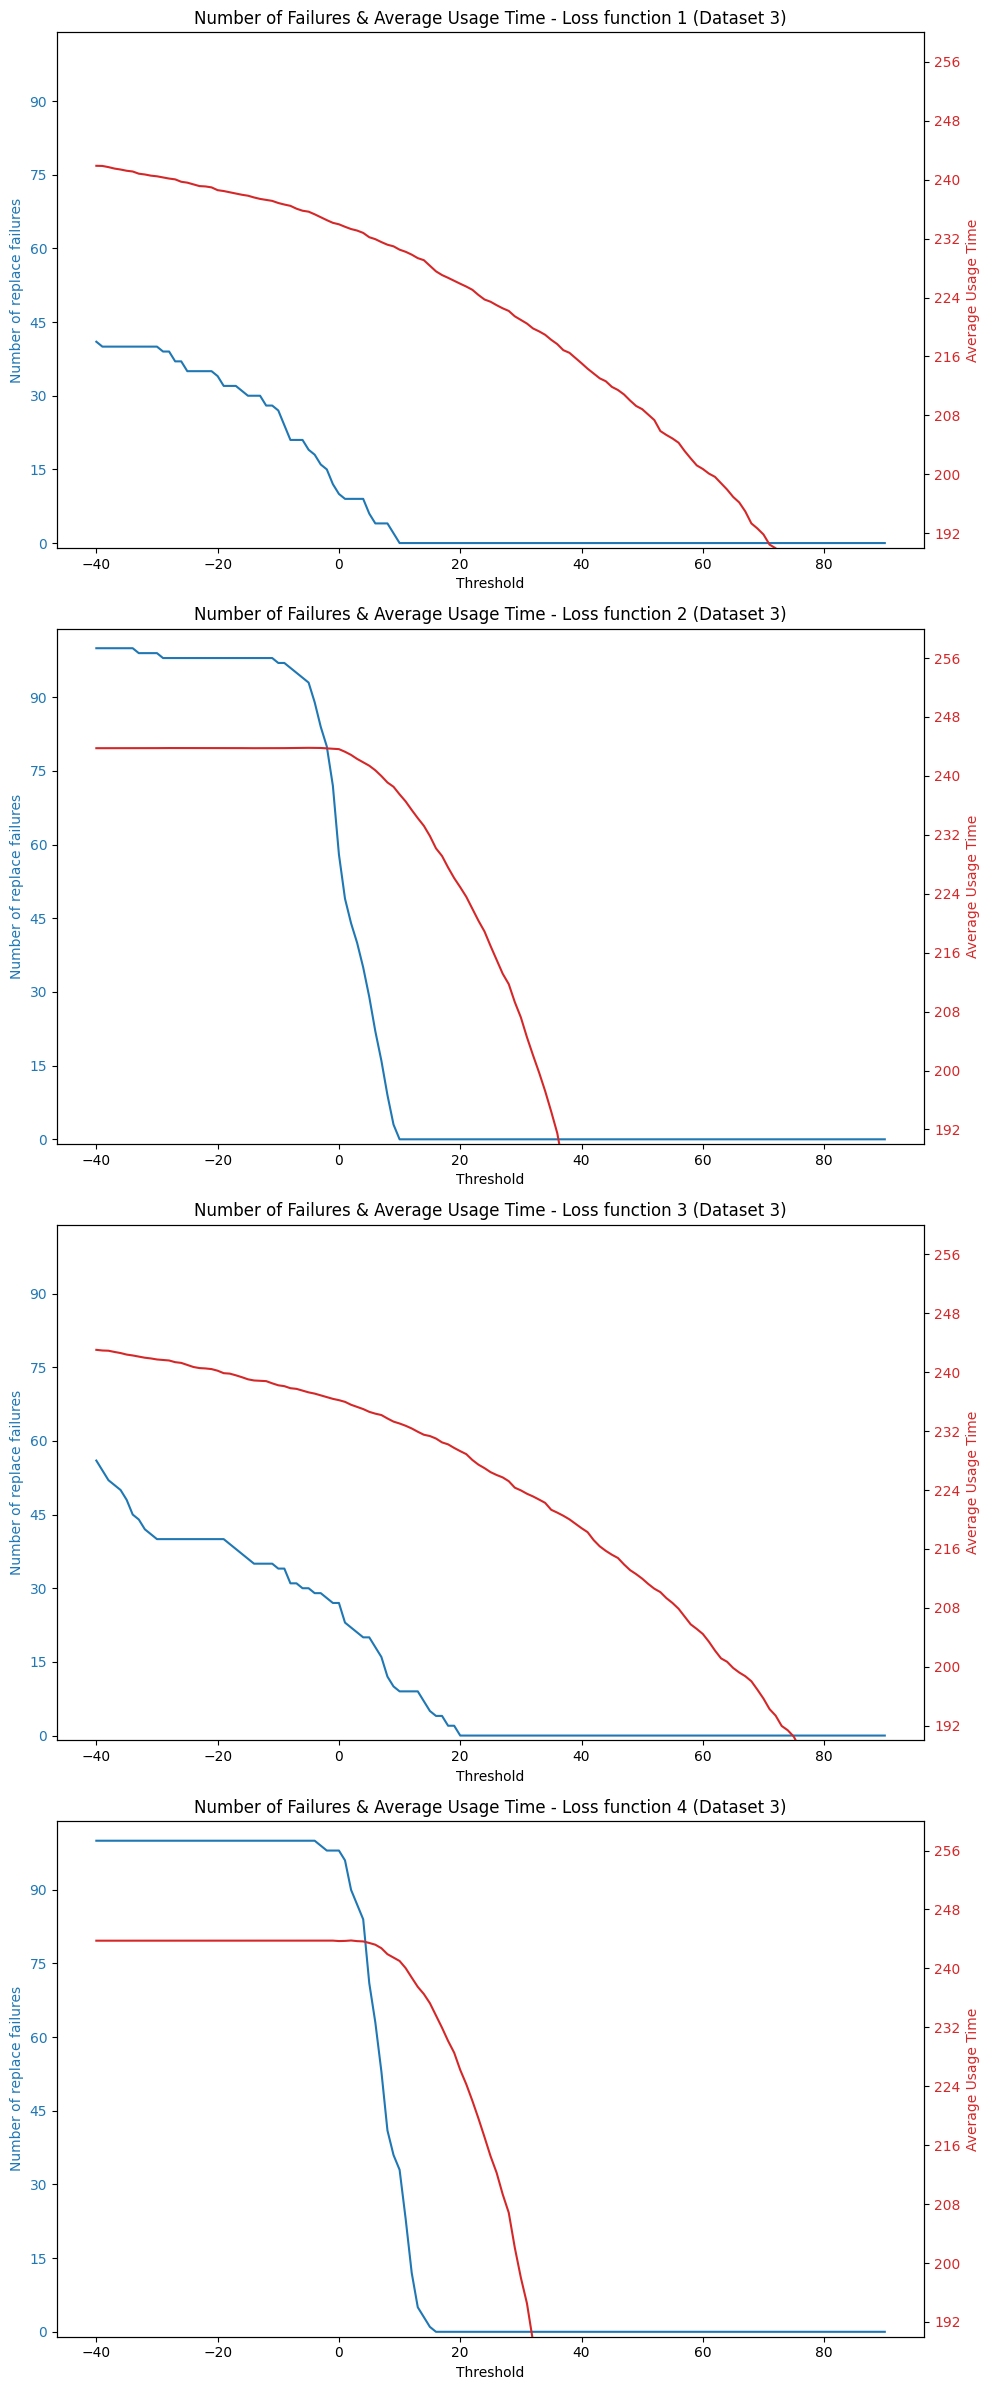

In [74]:
fig, axs = plt.subplots(len(full_nan_counts_and_cost_df_list), 1, figsize=(10, 6*len(full_nan_counts_and_cost_df_list)))

# 데이터프레임들을 저장한 리스트인 nan_counts_and_cost_df_list 내의 각 데이터프레임에 대해 반복 수행
for i, full_nan_counts_and_cost_df in enumerate(full_nan_counts_and_cost_df_list, start=1):
    ax1 = axs[i-1]

    # 왼쪽 Y축 그래프 (Number of failures)
    color = 'tab:blue'
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Number of replace failures', color=color)
    ax1.plot(full_nan_counts_and_cost_df['Threshold'], full_nan_counts_and_cost_df['Number of replace failures'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    #ax1.set_ylim(-1,104) ### for Dataset1
    #ax1.set_ylim(-5,270) ### for Dataset2
    ax1.set_ylim(-1,104) ### for Dataset3
    #ax1.set_ylim(-5,260) ### for Dataset4

    # 오른쪽 Y축 그래프 (Average Usage Time)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Average Usage Time', color=color)
    ax2.plot(full_nan_counts_and_cost_df['Threshold'], full_nan_counts_and_cost_df['Average usage time'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    #ax2.set_ylim(150,220) ### for Dataset1
    #ax2.set_ylim(135,220) ### for Dataset2
    ax2.set_ylim(190,260) ### for Dataset3
    #ax2.set_ylim(180,260) ### for Dataset4

    # 그래프 제목 설정
    #ax1.set_title(f'Number of Failures & Average Usage Time - Loss function {i} (Dataset 1)')
    #ax1.set_title(f'Number of Failures & Average Usage Time - Loss function {i} (Dataset 2)')
    ax1.set_title(f'Number of Failures & Average Usage Time - Loss function {i} (Dataset 3)')
    #ax1.set_title(f'Number of Failures & Average Usage Time - Loss function {i} (Dataset 4)')

# 그래프 보이기
plt.tight_layout()  # subplot 간격 조정
plt.show()

Average Cost

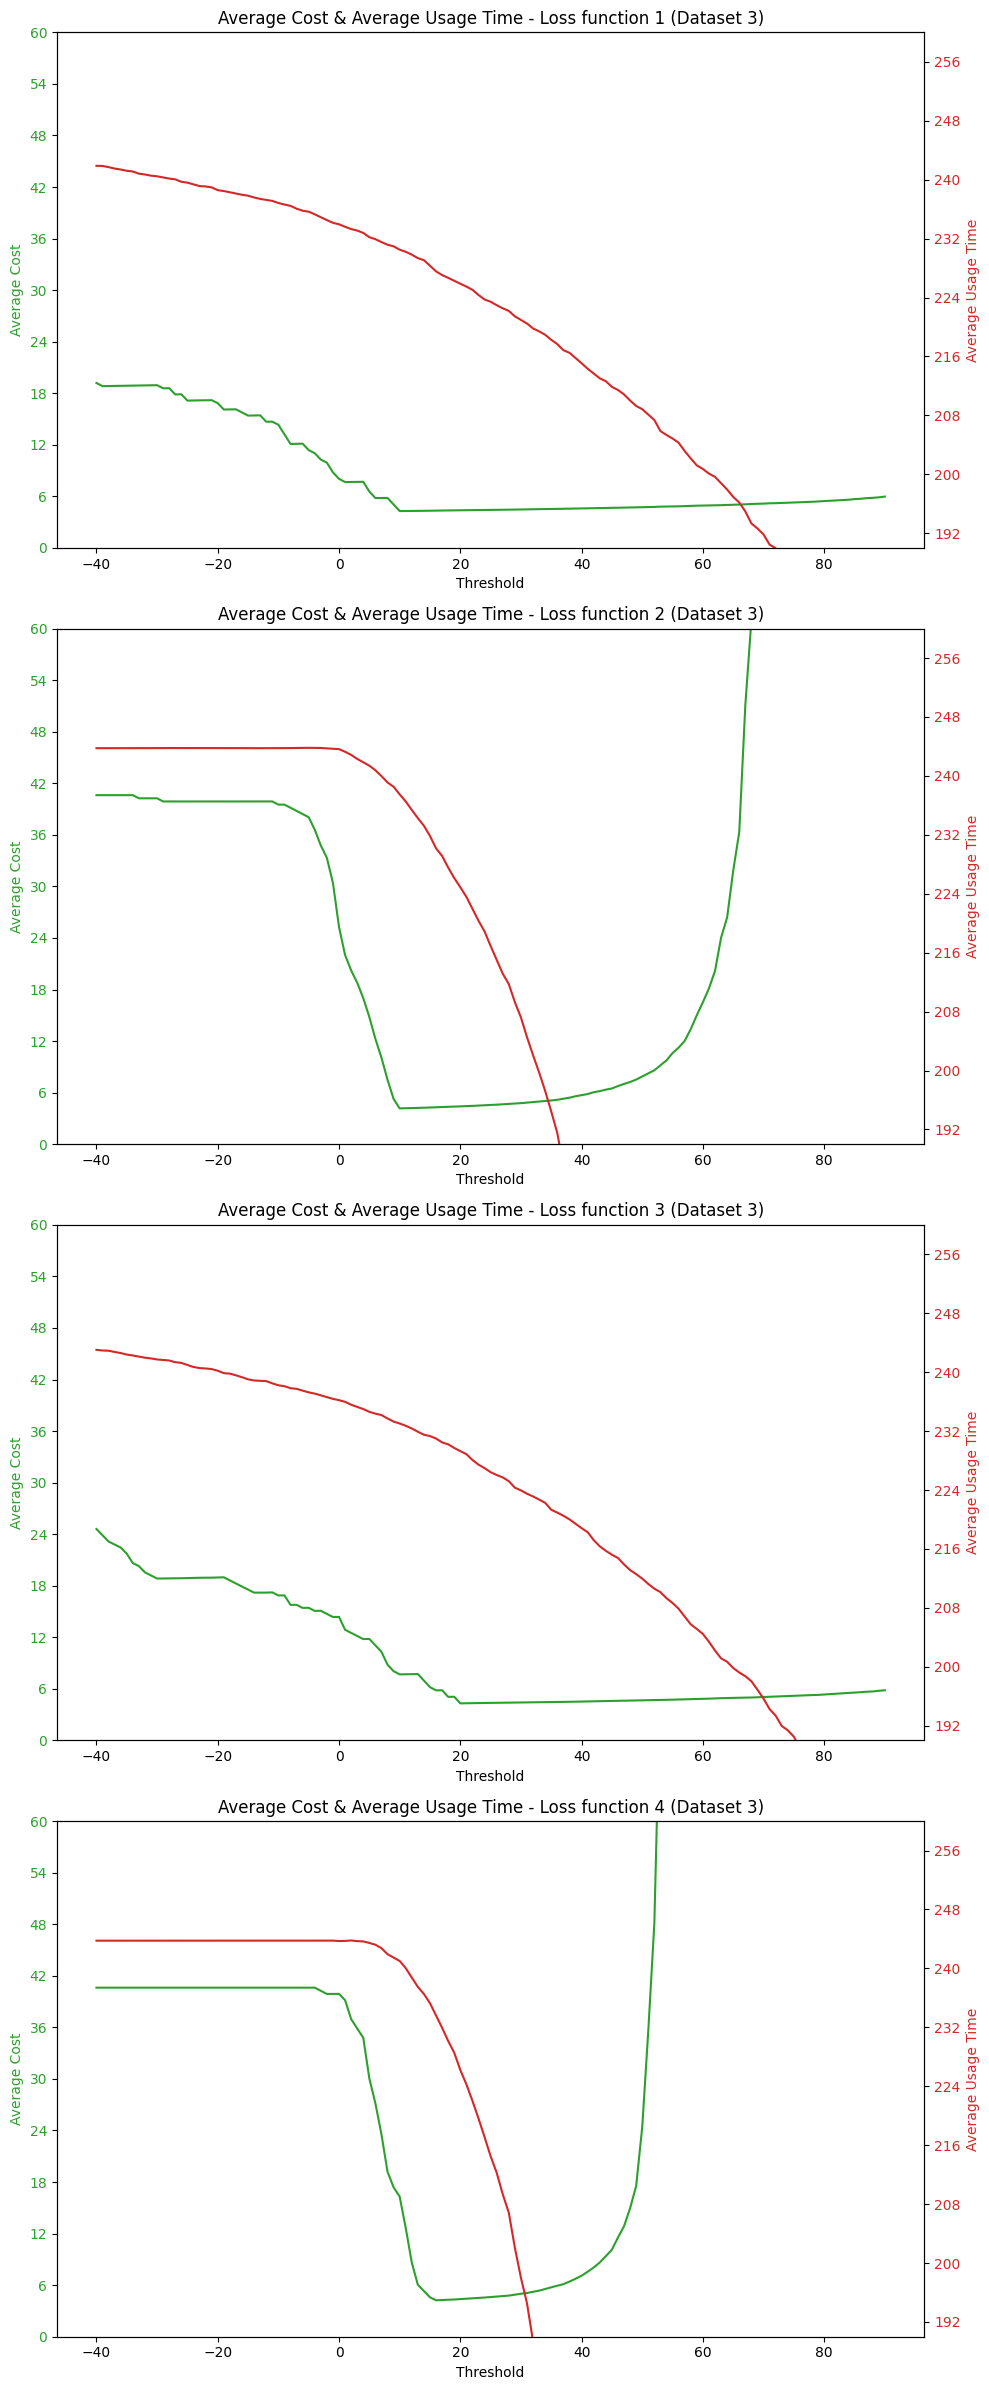

In [75]:
fig, axs = plt.subplots(len(full_nan_counts_and_cost_df_list), 1, figsize=(10, 6*len(full_nan_counts_and_cost_df_list)))

# 데이터프레임들을 저장한 리스트인 nan_counts_and_cost_df_list 내의 각 데이터프레임에 대해 반복 수행
for i, full_nan_counts_and_cost_df in enumerate(full_nan_counts_and_cost_df_list, start=1):
    ax1 = axs[i-1]

    # 왼쪽 Y축 그래프 (Average Cost)
    color = 'tab:green'
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Average Cost', color=color)
    ax1.plot(full_nan_counts_and_cost_df['Threshold'], full_nan_counts_and_cost_df['Total Cost'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    #ax1.set_ylim(0,60) ### for dataset1
    #ax1.set_ylim(0,60) ### for dataset2
    ax1.set_ylim(0,60) ### for dataset3
    #ax1.set_ylim(0,60) ### for dataset4
    """
    # 오른쪽 Y축 그래프 (Total Number of Engines Used)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Total Number of Engines Used', color=color)
    ax2.plot(full_nan_counts_and_cost_df['Threshold'], full_nan_counts_and_cost_df['Last index'] + 1, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    ax2.set_ylim(75,100)
    """
    # 오른쪽 Y축 그래프 (Average Usage Time)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Average Usage Time', color=color)
    ax2.plot(full_nan_counts_and_cost_df['Threshold'], full_nan_counts_and_cost_df['Average usage time'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))  # 눈금을 정수로 표시
    #ax2.set_ylim(150,220) ### for Dataset1
    #ax2.set_ylim(0,220) ### for Dataset2
    ax2.set_ylim(190,260) ### for Dataset3
    #ax2.set_ylim(-0.5,260) ### for Dataset4

    # 그래프 제목 설정
    #ax1.set_title(f'Average Cost & Average Usage Time - Loss function {i} (Dataset 1)')
    #ax1.set_title(f'Average Cost & Average Usage Time - Loss function {i} (Dataset 2)')
    ax1.set_title(f'Average Cost & Average Usage Time - Loss function {i} (Dataset 3)')
    #ax1.set_title(f'Average Cost & Average Usage Time - Loss function {i} (Dataset 4)')

# 그래프 보이기
plt.tight_layout()  # subplot 간격 조정
plt.show()

**Scatter Plot - (Number of Failures vs. Average usage time)**

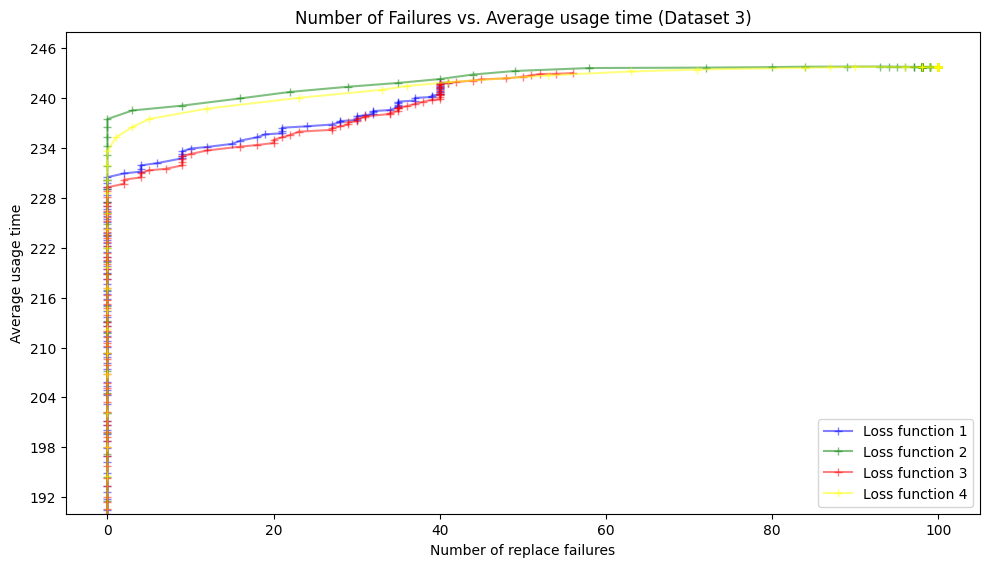

In [76]:
# Create a list of colors for each dataframe
colors = ['blue', 'green', 'red', 'yellow']

fig, ax = plt.subplots(figsize=(10, 6))

# Loop through the dataframes and plot scatter points with different colors
for i, full_nan_counts_and_cost_df in enumerate(full_nan_counts_and_cost_df_list):
    ax.plot(
        full_nan_counts_and_cost_df['Number of replace failures'],
        full_nan_counts_and_cost_df['Average usage time'],
        '+-',
        label=f'Loss function {i + 1}',
        color=colors[i],
        alpha=0.5
    )

# Set labels and title
ax.set_xlabel('Number of replace failures')
ax.set_ylabel('Average usage time')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 1)')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 2)')
ax.set_title('Number of Failures vs. Average usage time (Dataset 3)')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 4)')

# Add legend
ax.legend()

# Set integer ticks for y-axes
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#ax.set_ylim(150,220) ### for dataset1
#ax.set_ylim(135,220) ### for dataset2
ax.set_ylim(190,248) ### for dataset3
#ax.set_ylim(180,260) ### for dataset4

ax.set_xlim(-5,105) ### for dataset1,3
#ax.set_xlim(-5,265) ### for dataset2
#ax.set_xlim(-5,255) ### for dataset4

# Set aspect ratio to make the plot square
ax.set_aspect('equal')

# Show the plot
plt.tight_layout()
plt.show()

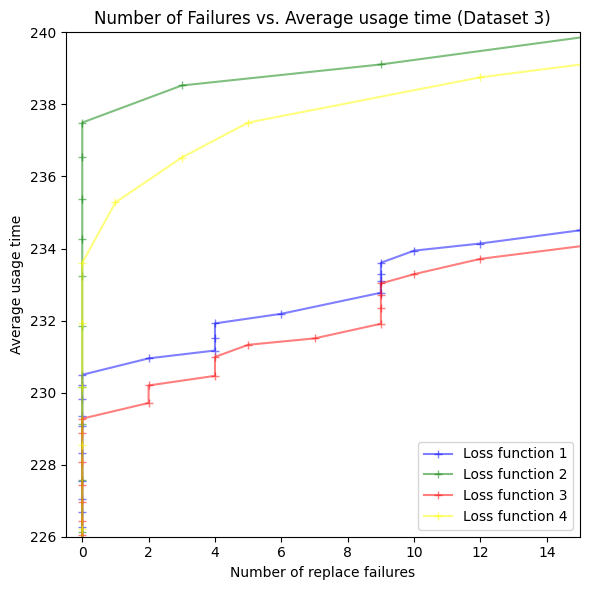

In [77]:
# Create a list of colors for each dataframe
colors = ['blue', 'green', 'red', 'yellow']

fig, ax = plt.subplots(figsize=(6, 6))

# Loop through the dataframes and plot scatter points with different colors
for i, full_nan_counts_and_cost_df in enumerate(full_nan_counts_and_cost_df_list):
    ax.plot(
        full_nan_counts_and_cost_df['Number of replace failures'],
        full_nan_counts_and_cost_df['Average usage time'], '+-',
        label=f'Loss function {i + 1}',
        color=colors[i],
        alpha=0.5
    )

# Set labels and title
ax.set_xlabel('Number of replace failures')
ax.set_ylabel('Average usage time')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 1)')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 2)')
ax.set_title('Number of Failures vs. Average usage time (Dataset 3)')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 4)')

# Add legend
ax.legend()

# Set integer ticks for y-axes
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

#ax.set_ylim(191,203) ### for dataset1
#ax.set_ylim(172,205) ### for dataset2
ax.set_ylim(226,240) ### for dataset3
#ax.set_ylim(190,237) ### for dataset4
ax.set_xlim(-0.5,15)

# Set aspect ratio to make the plot square
#ax.set_aspect('equal')

# Show the plot
plt.tight_layout()
plt.show()

# What is the best policy parameter?


**Experiment 1 - Gaussian Smoothing**

(Dataset 3, Loss function 2, Theta = 10)

(Dataset 4, Loss function 2, Theta = 10)

In [100]:
# Importing the library for using the 'deepcopy' method.
import copy

# Through the 'deepcopy' method, I assigned different addresses to lr2 and lr5, making them independent objects.
lr5 = copy.deepcopy(lr2)   # loss function 2의 w,b를 lr5에 저장
threshold_theta = 10       # initial theta = 10

# Hyper Parameter
GS_lr = 0.0001                  # learning rate
sd = 0.01                      # standard deviation
num_of_epsilon = 7              # for expectation -> mean(epsilon 1, epsilon 2, ... , epsilon n)
coef_of_MSE_w = 0.0001         # penalty term of MSE(W)
coef_of_MSE_b = 0.0001          # penalty term of MSE(b)
coef_of_MSE_theta = 0.0001      # penalty term of MSE(theta)

# save initial parameter (for calculate MSE)
initial_parameter = copy.deepcopy(lr5)
initial_theta = threshold_theta

# print
print(lr5.coef_)          # coef_ : w (21-dim)
print(lr5.intercept_)     # intercept_ : b (1-dim)
print(threshold_theta)

[ 0.00000000e+00 -7.95439227e+00 -8.66650105e+00 -1.57790014e+01
  8.88178420e-16  8.57208197e+00  2.80043562e+00 -4.82466080e+01
 -2.67289870e+01  4.90155222e-01 -2.45489924e+01 -2.32169455e+00
 -6.02261521e+01 -4.84968787e+00 -1.13735615e+01 -3.77475828e-15
 -7.06649263e+00  0.00000000e+00  0.00000000e+00  7.26755053e+00
  5.58250379e+00]
152.07684510255274
10


Scalar 값을 입력으로 받는 MSE 함수 정의

In [101]:
def mean_squared_error_scalar(y_true, y_pred):
    mse = (y_true - y_pred) ** 2
    return mse

In [72]:
# test code
"""
print(( GS_lr * ( ( gradient_w / (sd ** 2) ) + coef_of_MSE_w * (initial_parameter.coef_ - lr5.coef_) ) ))
print(( GS_lr * ( ( gradient_b / (sd ** 2)) + coef_of_MSE_b * (initial_parameter.intercept_ - lr5.intercept_) ) ))
print(( GS_lr * ( ( gradient_theta / (sd ** 2) ) + coef_of_MSE_theta * (initial_theta - threshold_theta) ) ))

print( GS_lr * ( ( gradient_w / (sd ** 2))))
print( GS_lr * ( ( gradient_b / (sd ** 2))))
print( GS_lr * ( ( gradient_theta / (sd ** 2))))
"""

'\nprint(( GS_lr * ( ( gradient_w / (sd ** 2) ) + coef_of_MSE_w * (initial_parameter.coef_ - lr5.coef_) ) ))\nprint(( GS_lr * ( ( gradient_b / (sd ** 2)) + coef_of_MSE_b * (initial_parameter.intercept_ - lr5.intercept_) ) ))\nprint(( GS_lr * ( ( gradient_theta / (sd ** 2) ) + coef_of_MSE_theta * (initial_theta - threshold_theta) ) ))\n    \nprint( GS_lr * ( ( gradient_w / (sd ** 2))))\nprint( GS_lr * ( ( gradient_b / (sd ** 2))))\nprint( GS_lr * ( ( gradient_theta / (sd ** 2))))\n'

In [102]:
## 'Epsilon 여러개 뽑는 version' + 'penalty term'으로 convergence 안정화 ##


# Initialize the DataFrame to store results
simul_result_df = pd.DataFrame(columns=['W', 'b', 'Theta', 'Average usage time', 'Average cost', 'Number of failure'])

# Define the number of iterations (n)
n = 3000  # Change this to the desired number of iterations

# Define gradient (누적 gradient를 저장해두고 계산하기 위해)   # w, b, theta는 누적 저장하지 않음.
#gradient_w = np.random.normal(0,0,21)
#gradient_b = 0
#gradient_theta = 0


for i in range(n):
    # Epsilon ~ N(0,0.1)
    epsilon_w = np.mean([np.random.normal(0, sd, 21) for _ in range(num_of_epsilon)], axis=0)
    epsilon_b = np.mean([np.random.normal(0, sd, 1) for _ in range(num_of_epsilon)])
    epsilon_theta = np.mean([np.random.normal(0, sd, 1) for _ in range(num_of_epsilon)])

    lr5.coef_ += epsilon_w
    lr5.intercept_ += epsilon_b
    threshold_theta += epsilon_theta

    y_full_prediction = lr5.predict(X_full_1_s)

    # Merge dataframe (label + data)
    y_full_prediction_df = pd.DataFrame(y_full_prediction, columns=['predicted RUL'])
    merged_full_prediction_df = pd.concat([X_full_index_names, y_full_prediction_df, y_full], axis=1)

    cumulative_operation_time = 0
    total_cost = 0
    average_cost = 0

    by_threshold_full_prediction_df = pd.DataFrame(columns=['unit_number', 'actual operation time', 'actual RUL', 'Cumulative Operation Time', 'Total Cost'])
    grouped = merged_full_prediction_df.groupby('unit_number')

    for unit, group in grouped:
        operation_time = None
        max_RUL = group['RUL'].max()

        for index, row in group.iterrows():
            if row['predicted RUL'] <= threshold_theta:
                operation_time = row['time_cycles']
                cumulative_operation_time += operation_time
                total_cost += REPLACE_COST
                break

        if pd.isna(operation_time):
            cumulative_operation_time += max_RUL
            total_cost += FAILURE_COST

        average_cost = (total_cost / cumulative_operation_time)
        by_threshold_full_prediction_df = by_threshold_full_prediction_df.append({'unit_number': unit, 'actual operation time': operation_time,
                                                                                  'actual RUL': max_RUL, 'Cumulative Operation Time': cumulative_operation_time,
                                                                                  'Average Cost' : average_cost, 'Total Cost': total_cost}, ignore_index=True)

    simul_average_usage_time = by_threshold_full_prediction_df['Cumulative Operation Time'].iloc[-1] / (len(by_threshold_full_prediction_df.index) + 1)
    simul_average_cost_by_threshold = by_threshold_full_prediction_df['Average Cost'].iloc[-1]
    simul_nan_count = by_threshold_full_prediction_df.loc[:, 'actual operation time'].isna().sum()

    # 앞에서 넣은 epsilon을 다시 제거하고, 원래의 parameter로 되돌림.
    lr5.coef_ -= epsilon_w
    lr5.intercept_ -= epsilon_b
    threshold_theta -= epsilon_theta

    # Expectation 내의 gradient 부분만 계산
    gradient_w = simul_average_cost_by_threshold * epsilon_w          # "f(w+eps, b+eps, theta+eps) * [ epsilon vector ]"에서 w 부분
    gradient_b = simul_average_cost_by_threshold * epsilon_b          # b 부분
    gradient_theta = simul_average_cost_by_threshold * epsilon_theta  # theta 부분


    # test code
    #print(( GS_lr * ( ( gradient_w / (sd ** 2) ) + coef_of_MSE_w * (initial_parameter.coef_ - lr5.coef_) ) ))
    #print(( GS_lr * ( ( gradient_b / (sd ** 2)) + coef_of_MSE_b * (initial_parameter.intercept_ - lr5.intercept_) ) ))
    #print(( GS_lr * ( ( gradient_theta / (sd ** 2) ) + coef_of_MSE_theta * (initial_theta - threshold_theta) ) ))

    #print( GS_lr * ( ( gradient_w / (sd ** 2))))
    #print( GS_lr * ( ( gradient_b / (sd ** 2))))
    #print( GS_lr * ( ( gradient_theta / (sd ** 2))))


    # [W,b,theta] update  # 여기에 MSE penalty를 넣어줘야 함.
    lr5.coef_ -= ( GS_lr * ( ( gradient_w / (sd ** 2) ) + coef_of_MSE_w * (initial_parameter.coef_ - lr5.coef_) ) )
    lr5.intercept_ -= ( GS_lr * ( ( gradient_b / (sd ** 2)) + coef_of_MSE_b * (initial_parameter.intercept_ - lr5.intercept_) ) )
    threshold_theta -= ( GS_lr * ( ( gradient_theta / (sd ** 2) ) + coef_of_MSE_theta * (initial_theta - threshold_theta) ) )

    # Append the results to the DataFrame
    simul_result_df = simul_result_df.append({'Iteration' : i + 1, 'W': lr5.coef_.tolist(), 'b': lr5.intercept_.item(), 'Theta': threshold_theta.item(),
                                              'Average usage time': simul_average_usage_time, 'Average cost': simul_average_cost_by_threshold,
                                              'Number of failure': simul_nan_count}, ignore_index=True)

  #  print("Iteration : ", i + 1, "Average usage time : ", "{:.3f}".format(simul_average_usage_time),
  #        ", Average cost : ", "{:.3f}".format(simul_average_cost_by_threshold), ", Number of failures : ", simul_nan_count )

In [103]:
# Print or use the simul_result_df as needed
print(simul_result_df)

                                                      W           b  \
0     [0.0069987588550583305, -7.946505356816898, -8...  152.070222   
1     [-0.006021164960824492, -7.924384943811519, -8...  152.061238   
2     [0.010925349673850625, -7.905062250012199, -8....  152.047480   
3     [0.036839198710272095, -7.881387094002219, -8....  152.060166   
4     [0.019339680105352728, -7.873752047902414, -8....  152.058042   
...                                                 ...         ...   
2995  [1.6448664205706043, -7.926954860389023, -8.03...  153.603325   
2996  [1.6234497098624605, -7.930993516068848, -8.03...  153.633331   
2997  [1.6182220774333602, -7.934227316336946, -8.04...  153.629509   
2998  [1.6203351704997124, -7.912750511279937, -8.05...  153.659110   
2999  [1.6090262381165272, -7.8811165308804005, -8.0...  153.644802   

          Theta  Average usage time  Average cost Number of failure  Iteration  
0     10.010775          237.495050      4.168925                 

In [104]:
# Find optimal parameter
optimal_average_cost_row = simul_result_df.iloc[simul_result_df['Average cost'].idxmin()]
print(optimal_average_cost_row)

W                     [1.5526919665899148, -8.048633823874608, -8.07...
b                                                             153.35627
Theta                                                         11.183438
Average usage time                                           238.891089
Average cost                                                   4.144562
Number of failure                                                     0
Iteration                                                        2842.0
Name: 2841, dtype: object


In [105]:
optimal_average_cost_row['W']

[1.5526919665899148,
 -8.048633823874608,
 -8.071138485751366,
 -16.242001836294193,
 -0.09951509459183892,
 9.354288310298827,
 2.65138477545816,
 -48.50215889502686,
 -27.365738694038452,
 0.36616851270691697,
 -25.2060961029657,
 -0.5008547112680368,
 -58.66159486978797,
 -4.617109695708078,
 -12.56117898112166,
 -0.3284767082680381,
 -7.970430152582186,
 0.34212614385945656,
 -0.20720853070133496,
 8.945838643175929,
 5.616041844172953]

In [ ]:
#optimal_average_cost_row = simul_result_df.iloc[0]
#optimal_average_cost_row['W']

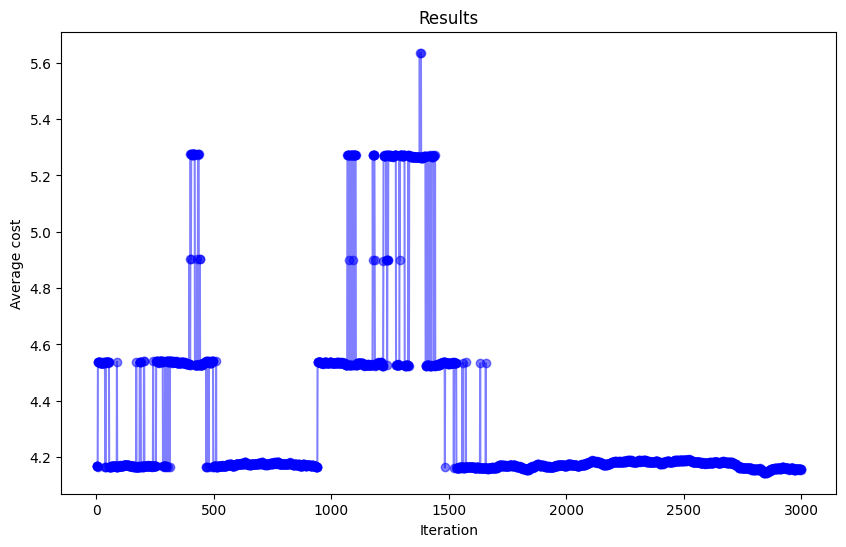

In [112]:
plt.figure(figsize=(10, 6))

# 'Iteration'을 x축으로, 'Average cost'을 y축으로 하는 그래프 그리기
plt.plot(simul_result_df['Iteration'], simul_result_df['Average cost'],
         marker='o', color='b', alpha=0.5)

# 그래프에 레이블 추가
plt.xlabel('Iteration')
plt.ylabel('Average cost')
plt.title('Results')

#plt.ylim(4.14, 4.2)
#plt.xlim(0, 100)

# 그래프 표시
#plt.grid(True)  # 그리드 추가
plt.show()

**Plot에 optimal point 찍어보기**

"Optimal parameter로 성능 재현"

In [107]:
#optimal_parameter = simul_result_df.iloc[213]    # optimal row
optimal_parameter = optimal_average_cost_row  # optimal row
optimal_w = np.array(optimal_parameter['W'])     # optimal paramter에서 W 추출
optimal_b = optimal_parameter['b']     # optimal paramter에서 b 추출
optimal_theta = optimal_parameter['Theta'] # optimal paramter에서 Theta

lr5.coef_ = optimal_w
lr5.intercept_ = optimal_b
threshold_theta = optimal_theta

y_optimal_prediction = lr5.predict(X_full_1_s)

 # Merge dataframe (label + data)
y_optimal_prediction_df = pd.DataFrame(y_optimal_prediction, columns=['predicted RUL'])
merged_optimal_prediction_df = pd.concat([X_full_index_names, y_optimal_prediction_df, y_full], axis=1)

cumulative_operation_time = 0
total_cost = 0
average_cost = 0


by_threshold_optimal_prediction_df = pd.DataFrame(columns=['unit_number', 'actual operation time', 'actual RUL', 'Cumulative Operation Time', 'Total Cost'])
grouped = merged_optimal_prediction_df.groupby('unit_number')

for unit, group in grouped:
    operation_time = None
    max_RUL = group['RUL'].max()

    for index, row in group.iterrows():
        if row['predicted RUL'] <= threshold_theta:
            operation_time = row['time_cycles']
            cumulative_operation_time += operation_time
            total_cost += REPLACE_COST
            break

    if pd.isna(operation_time):
        cumulative_operation_time += max_RUL
        total_cost += FAILURE_COST

    average_cost = (total_cost / cumulative_operation_time)
    by_threshold_optimal_prediction_df = by_threshold_optimal_prediction_df.append({'unit_number': unit, 'actual operation time': operation_time,
                                                                              'actual RUL': max_RUL, 'Cumulative Operation Time': cumulative_operation_time,
                                                                              'Average Cost' : average_cost, 'Total Cost': total_cost}, ignore_index=True)

optimal_average_usage_time = by_threshold_optimal_prediction_df['Cumulative Operation Time'].iloc[-1] / (len(by_threshold_optimal_prediction_df.index) + 1)
optimal_average_cost_by_threshold = by_threshold_optimal_prediction_df['Average Cost'].iloc[-1]
optimal_number_of_failure = by_threshold_optimal_prediction_df.loc[:, 'actual operation time'].isna().sum()


print("Optimal : ", "Average usage time : ", "{:.3f}".format(optimal_average_usage_time),
      ", Average cost : ", "{:.3f}".format(optimal_average_cost_by_threshold), ", Number of failures : ", optimal_number_of_failure )

Optimal :  Average usage time :  238.851 , Average cost :  4.145 , Number of failures :  0


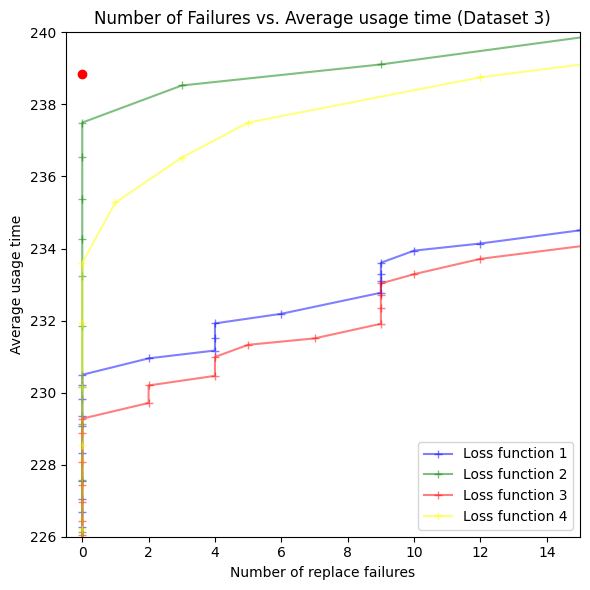

In [108]:
# Create a list of colors for each dataframe
colors = ['blue', 'green', 'red', 'yellow']

fig, ax = plt.subplots(figsize=(6, 6))

# Loop through the dataframes and plot scatter points with different colors
for i, full_nan_counts_and_cost_df in enumerate(full_nan_counts_and_cost_df_list):
    ax.plot(
        full_nan_counts_and_cost_df['Number of replace failures'],
        full_nan_counts_and_cost_df['Average usage time'], '+-',
        label=f'Loss function {i + 1}',
        color=colors[i],
        alpha=0.5
    )

# Set labels and title
ax.set_xlabel('Number of replace failures')
ax.set_ylabel('Average usage time')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 1)')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 2)')
ax.set_title('Number of Failures vs. Average usage time (Dataset 3)')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 4)')

# Add legend
ax.legend()

# Set integer ticks for y-axes
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

#ax.set_ylim(191,203) ### for dataset1
#ax.set_ylim(172,205) ### for dataset2
ax.set_ylim(226,240) ### for dataset3
#ax.set_ylim(190,237) ### for dataset4
ax.set_xlim(-0.5,15)

# Set aspect ratio to make the plot square
#ax.set_aspect('equal')


###########################################################################################

optimal_x = optimal_number_of_failure
optimal_y = optimal_average_usage_time

# Plot a point using the extracted values
ax.plot(
    optimal_x,
    optimal_y,
    'ro',  # 'ro'는 빨간색 원형 점.
    label='Optimal Point'
)
###########################################################################################

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# epsilon이 포함된 상태에서의 optimal NoF와 Average usage time (실제 저장된 w,b,theta를 이용한 값이 아님)
"""
# Create a list of colors for each dataframe
colors = ['blue', 'green', 'red', 'yellow']

fig, ax = plt.subplots(figsize=(6, 6))

# Loop through the dataframes and plot scatter points with different colors
for i, full_nan_counts_and_cost_df in enumerate(full_nan_counts_and_cost_df_list):
    ax.plot(
        full_nan_counts_and_cost_df['Number of replace failures'],
        full_nan_counts_and_cost_df['Average usage time'], '+-',
        label=f'Loss function {i + 1}',
        color=colors[i],
        alpha=0.5
    )

# Set labels and title
ax.set_xlabel('Number of replace failures')
ax.set_ylabel('Average usage time')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 1)')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 2)')
ax.set_title('Number of Failures vs. Average usage time (Dataset 3)')
#ax.set_title('Number of Failures vs. Average usage time (Dataset 4)')

# Add legend
ax.legend()

# Set integer ticks for y-axes
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

#ax.set_ylim(191,203) ### for dataset1
#ax.set_ylim(172,205) ### for dataset2
ax.set_ylim(226,240) ### for dataset3
#ax.set_ylim(190,237) ### for dataset4
ax.set_xlim(-0.5,15)

# Set aspect ratio to make the plot square
#ax.set_aspect('equal')

###########################################################################################
# Extract data from a specific row of result_df (e.g., row 50)
optimal_point_row = simul_result_df.iloc[213]  # Change the index to the desired row number

optimal_x = optimal_point_row['Number of failure']
optimal_y = optimal_point_row['Average usage time']

# Plot a point using the extracted values
ax.plot(
    optimal_x,
    optimal_y,
    'ro',  # 'ro'는 빨간색 원형 점.
    label='Optimal Point'
)
###########################################################################################

# Show the plot
plt.tight_layout()
plt.show()
"""

# Policy-based RL (REINFORCE Algorithm)

Stochastic policy version

In [ ]:
# Train dataset을 적절히 나눠서 Train, Test를 진행 (RUL prediction에서는 70:30 적용했음).
# Train dataset에서 unit을 변경하며 cumulative reward의 최대화 수행.

# Time cycle 10,000 (혹은 1,000)으로 고정해서 RL을 적용 (Threshold도 함께 학습)
# Threshold를 학습하려면 REINFORE Alg. 같은 stochastic policy가 아니라, Deterministic Policy based RL style로 가야하지 않을까?
# Deterministic policy based로 다시 생각해보자.
# Deterministic policy Gradient Algorithm (DPG; 2014)



Importing libraries (RL)

REINFORCE Algorithm

In [ ]:
# policy control parameter theta, y_bar (threshold도 학습의 대상으로 parameter에 들어감)